# Load library

# :warning:
This is an exploratory notebook. The useful one is `2-measure-performance.ipynb`
:warning:

In [1]:
# Import the necessary libraries
import sys
import os
PROJ_DIR = os.path.realpath(os.path.dirname(os.path.abspath('')))
sys.path.append(os.path.join(PROJ_DIR,'src'))

import xai_faithfulness_experiments_lib_edits as fl

/opt/miniconda3/envs/pytorch-quantus/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load data

In [82]:
import numpy as np

filename = 'avila_70_measures.npz'
data = fl.load_generated_data(os.path.join(PROJ_DIR, 'results', filename))

qmeans = data['qmeans']
qmeans_bas = data['qmean_bas']
qmean_invs = data['qmean_invs']

## Evaluating the metrics
Measure how good each of the metrics is at determining how exceptional a given ranking is.

The ground truth will be the z-score for each ranking. To determine it, one must model the distribution of all possible rankings, which is unfeasible in most cases but we can do here.

### Q-mean distribution

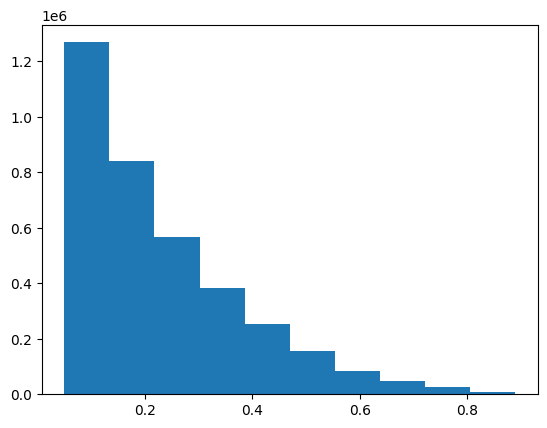

Avg:0.21869023144245148 | Std:0.16184645891189575


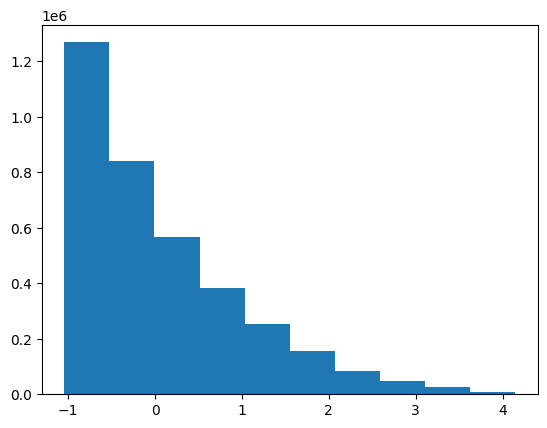

In [83]:
import matplotlib.pyplot as plt

plt.hist(qmeans, bins=10)
plt.show()


qmean_mean = np.mean(qmeans)
qmean_std = np.std(qmeans)

z_scores = ((qmeans - qmean_mean) / qmean_std).flatten()

print(f'Avg:{qmean_mean} | Std:{qmean_std}')
plt.hist(z_scores, bins=10)
plt.show()

(94053,)


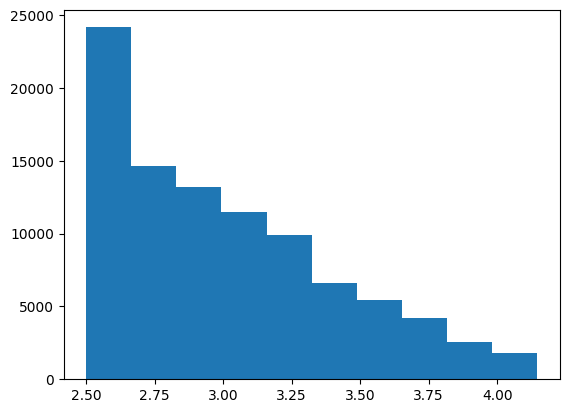

In [84]:
# Stratify z-index to be able to compare performance on different parts of the spectrum
indices = np.arange(z_scores.shape[0])

z_scores_numbered = np.vstack((z_scores, indices))

level_indices = []
boundaries = [float('-inf'), 0, 0.5, 1, 1.5, 2, 2.5]
for i in range(1,len(boundaries)+1):
    bottom_limit = boundaries[i-1]
    top_limit = float('inf')
    if i < len(boundaries):
        top_limit = boundaries[i]
    level_indices.append((z_scores_numbered[:,np.logical_and(bottom_limit<=z_scores, z_scores<top_limit)][1,:].astype(int),(bottom_limit, top_limit)))

exceptional_indices = level_indices[-1][0]

print(exceptional_indices.shape)

plt.hist(z_scores[exceptional_indices], bins=10)
plt.show()

In [134]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from scipy.stats import spearmanr

def show_performance(z_scores, estimator, estimator_name):
    estimator = estimator.flatten()

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))

    ax1.hist(estimator, bins=10)
    ax1.set_title(f'{estimator_name} distribution')

    pearson = np.corrcoef(z_scores,estimator)[0][1]
    spearman = spearmanr(z_scores, estimator)[0]
    
    print(f'Pearson correlation z-score vs {estimator_name}:{pearson}')
    print(f'Spearman correlation z-score vs {estimator_name}:{spearman}')
    #ax2.scatter(z_scores, estimator, s=1)
    #ax2.set_title(f'z_score vs {estimator_name}')

    # Heatmap on ax2
    heatmap, xedges, yedges = np.histogram2d(z_scores, estimator, bins=100)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    ax2.imshow(heatmap.T, origin='lower', extent=extent, aspect='auto', cmap='hot')
    ax2.set_title(f'Heatmap: z_score vs {estimator_name}')
    ax2.set_xlabel('z_score')
    ax2.set_ylabel(estimator_name)

    # Add a colorbar for the heatmap
    cbar = fig.colorbar(ax2.imshow(heatmap.T, origin='lower', extent=extent, aspect='auto', cmap='hot'), ax=ax2)
    cbar.set_label('Density')

    plt.show()

    mae = mean_absolute_error(z_scores, estimator)
    mse = mean_squared_error(z_scores, estimator)
    mape = mean_absolute_percentage_error(z_scores, estimator)

    #MAE distribution
    plt.hist(np.abs(z_scores-estimator), bins=100)
    plt.title(f'Error distribution for {estimator_name}')
    plt.show()

    print(f'MAE:{mae}\nMSE:{mse}\nMAPE:{mape}')
    return pearson,spearman,mae,mse,mape

### Qmean_bas

Determines the exceptionality of a ranking by comparing it to a single random ranking.

Pearson correlation z-score vs Qmean_bas:0.707436898161421
Spearman correlation z-score vs Qmean_bas:0.6758473617988408


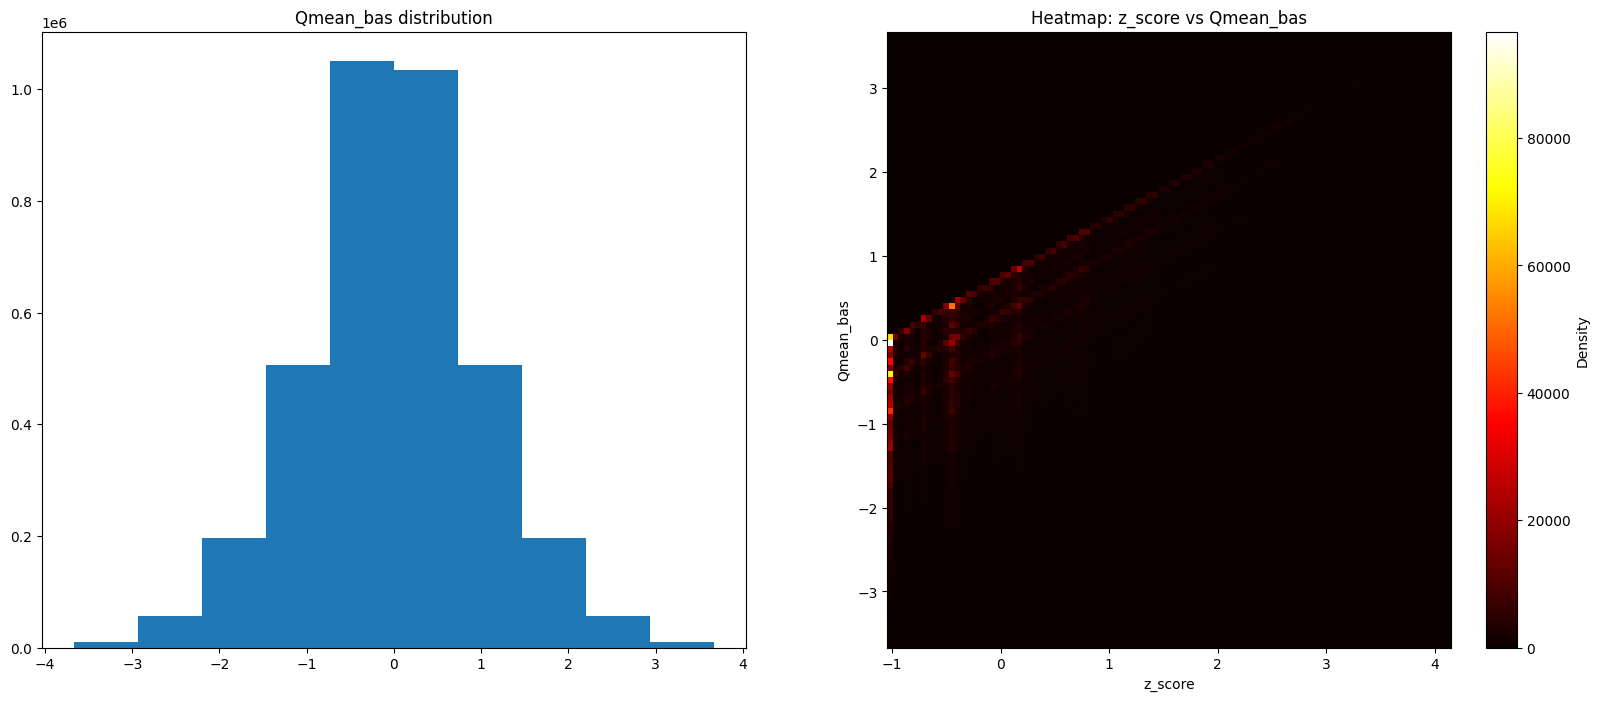

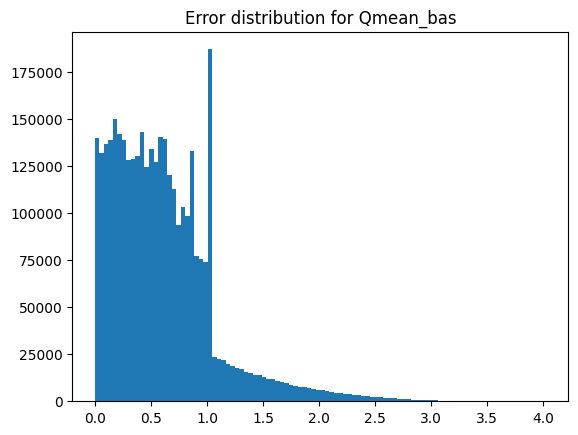

MAE:0.6093594431877136
MSE:0.5851259827613831
MAPE:5.199804782867432
Pearson correlation z-score vs Qmean_bas (exceptional):0.3717511497513567
Spearman correlation z-score vs Qmean_bas (exceptional):0.39908547281293444


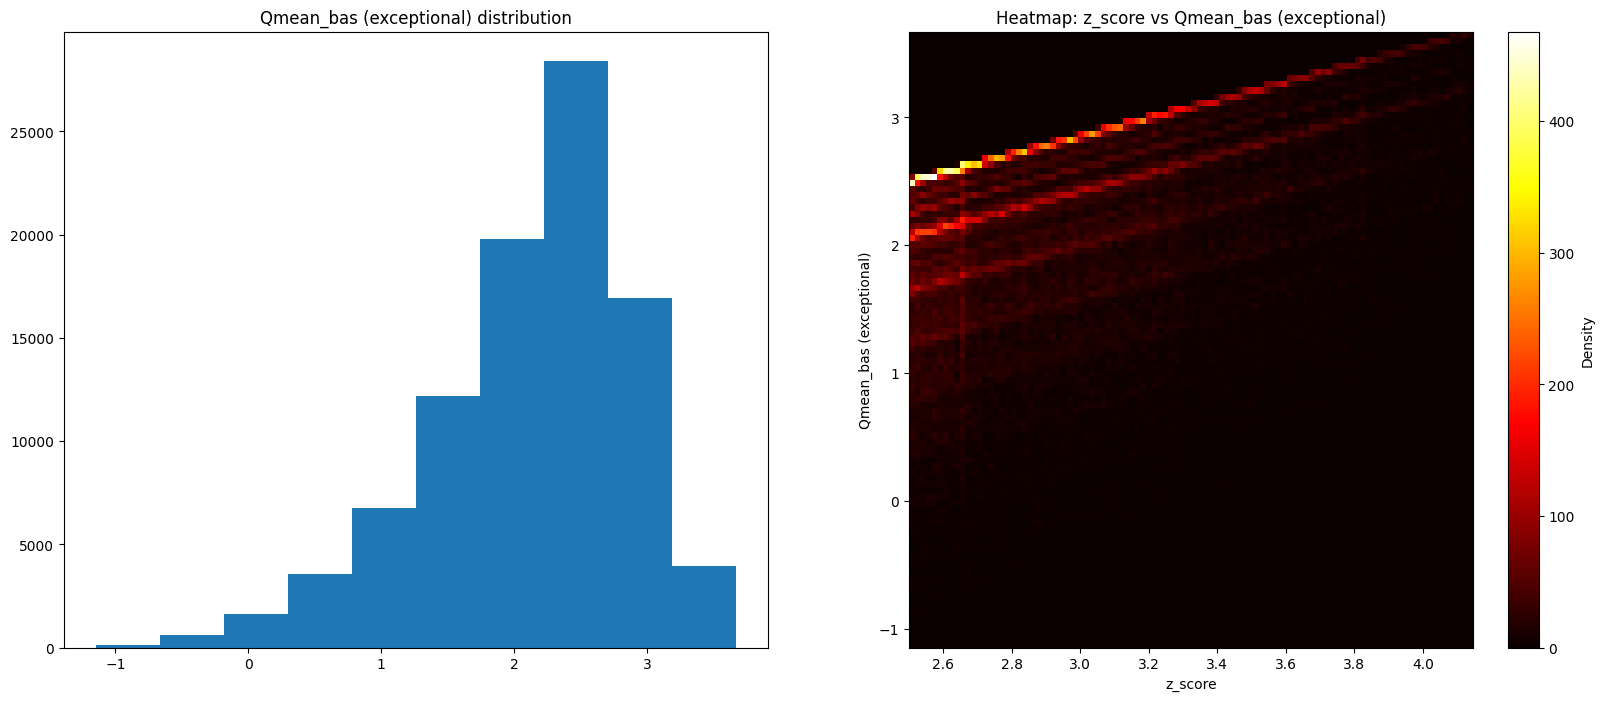

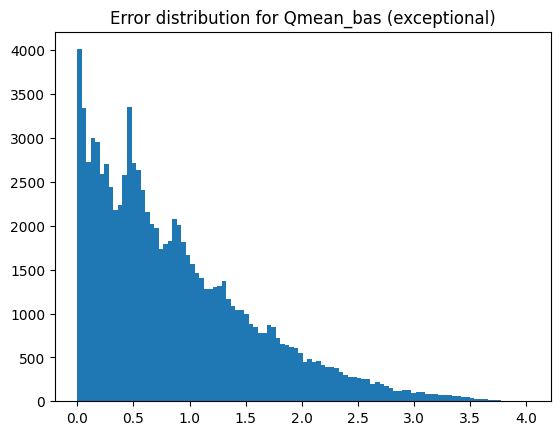

MAE:0.8824514746665955
MSE:1.2948969602584839
MAPE:0.29296228289604187


In [135]:
qmean_bas_standard = (qmeans_bas - np.mean(qmeans_bas)) / np.std(qmeans_bas)

qmean_results=show_performance(z_scores, qmean_bas_standard, 'Qmean_bas')
qmean_results_exceptional=show_performance(z_scores[exceptional_indices], qmean_bas_standard[exceptional_indices], 'Qmean_bas (exceptional)')

### Qmean_inv

Determines the exceptionality of a ranking by comparing it to the reversed ranking

Pearson correlation z-score vs Qmean_inv:0.8514821911685503
Spearman correlation z-score vs Qmean_inv:0.8474263905042759


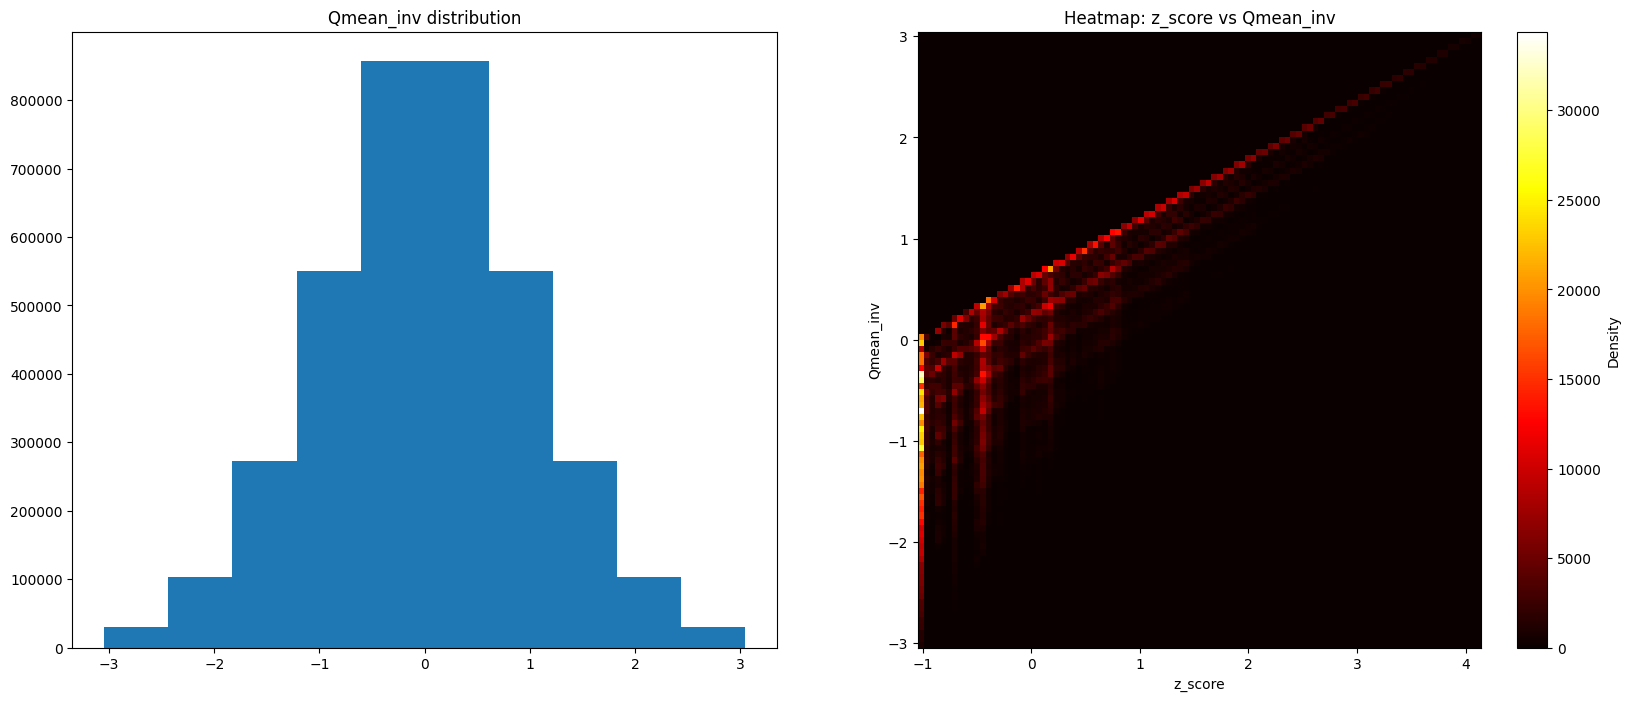

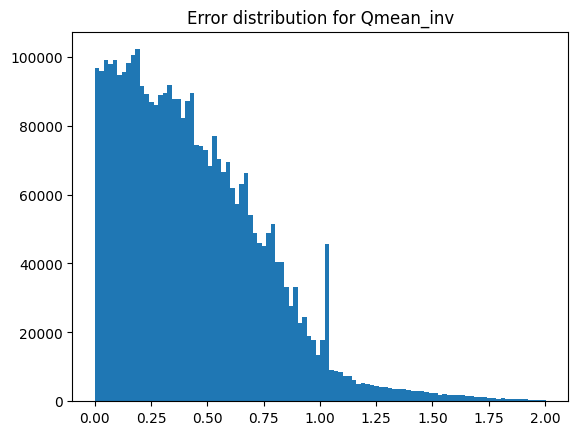

MAE:0.44182994961738586
MSE:0.2970356345176697
MAPE:3.5429277420043945
Pearson correlation z-score vs Qmean_inv (exceptional):0.8950735626223683
Spearman correlation z-score vs Qmean_inv (exceptional):0.8950454556372709


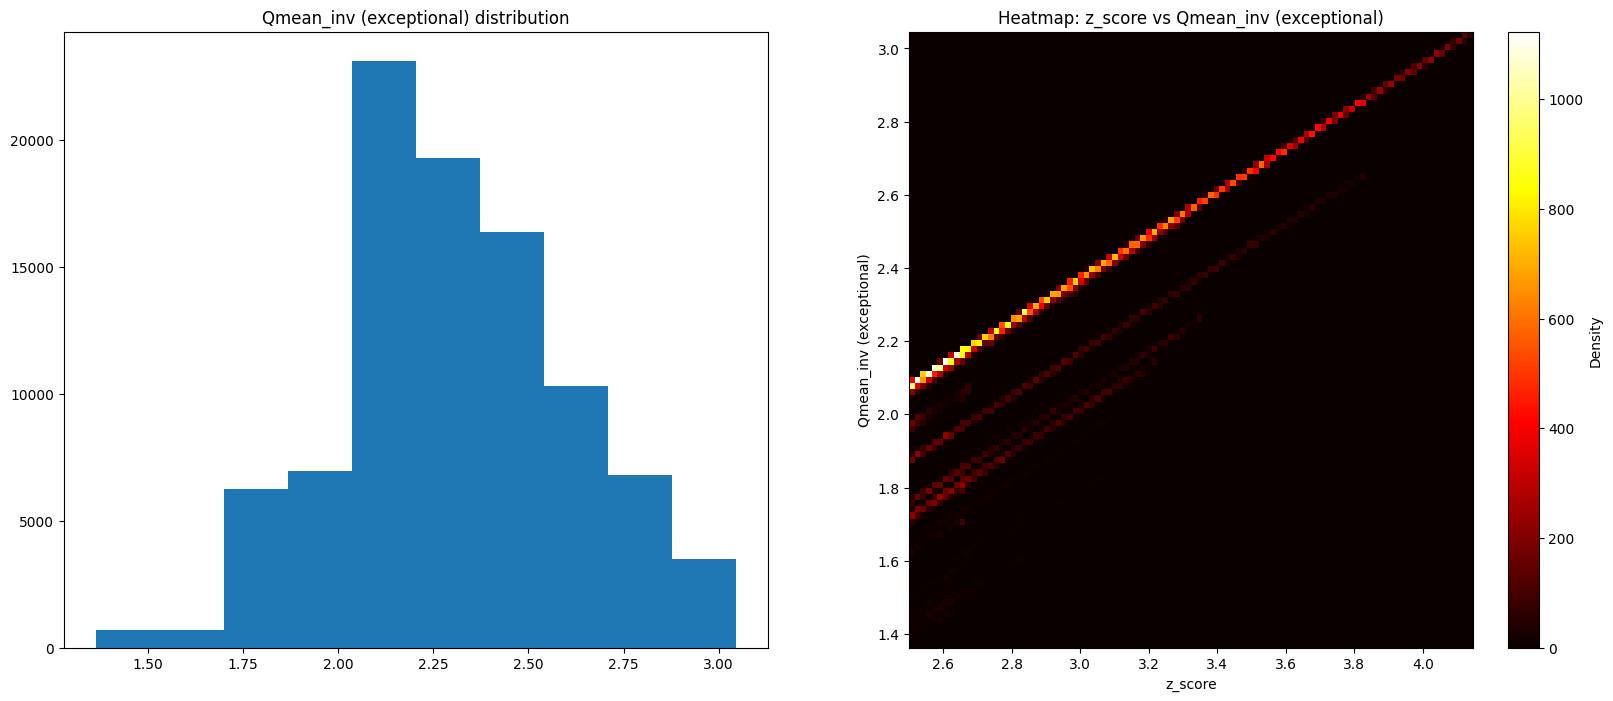

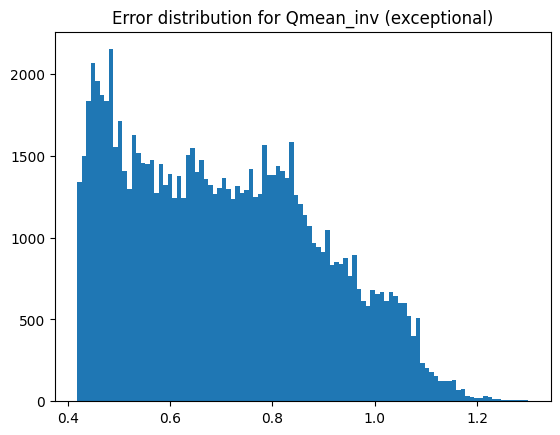

MAE:0.7058371305465698
MSE:0.5334177017211914
MAPE:0.23288802802562714


In [136]:
qmeans_inv_standard = (qmean_invs - np.mean(qmean_invs)) / np.std(qmean_invs)

qinv_results=show_performance(z_scores, qmeans_inv_standard, 'Qmean_inv')
qinv_results_exceptional=show_performance(z_scores[exceptional_indices], qmeans_inv_standard[exceptional_indices], 'Qmean_inv (exceptional)')

### Qmean_basX

Determines the exceptionality of a ranking by estimating mean and std with X random rankings

Pearson correlation z-score vs Qmean_bas2:0.8165629104478506
Spearman correlation z-score vs Qmean_bas2:0.769089655033795


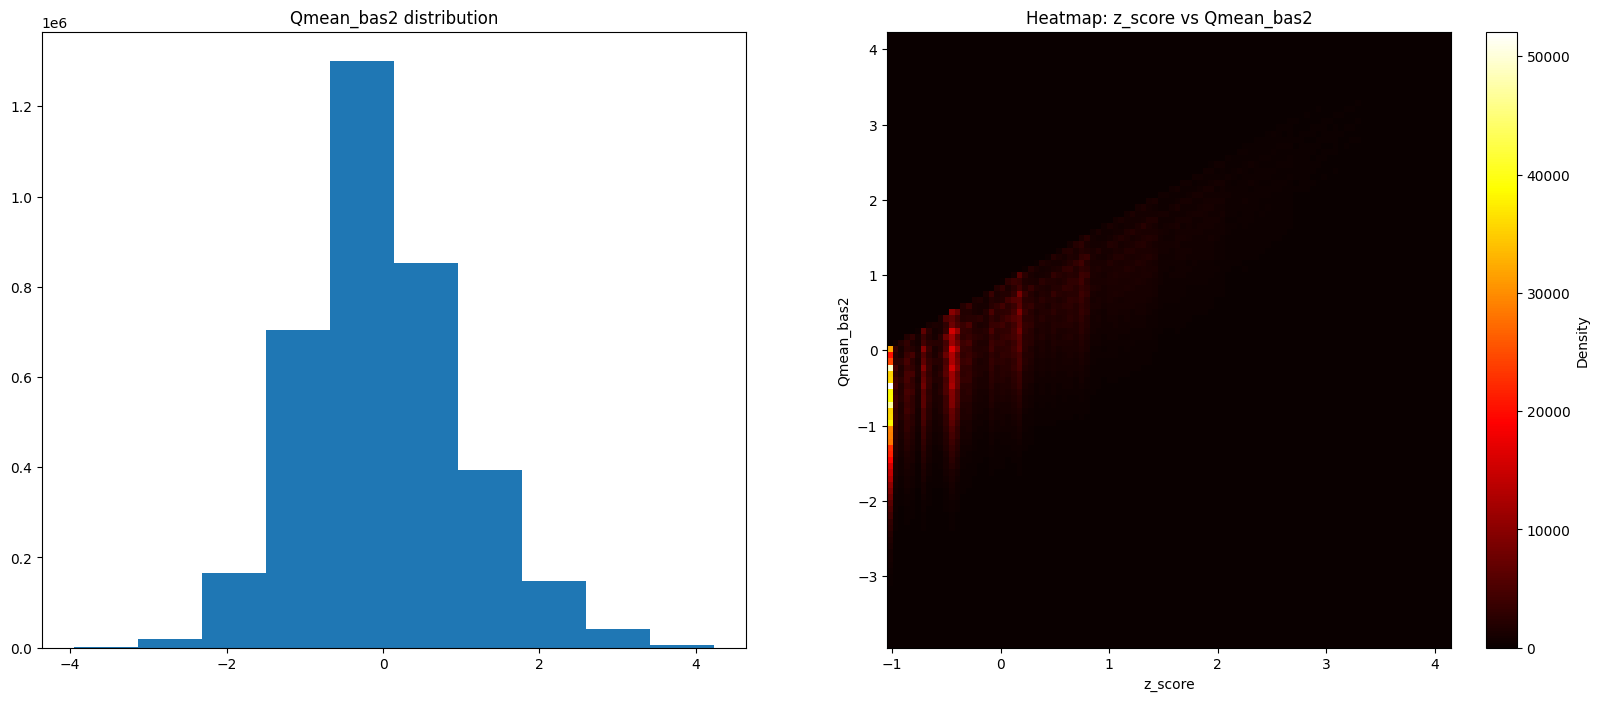

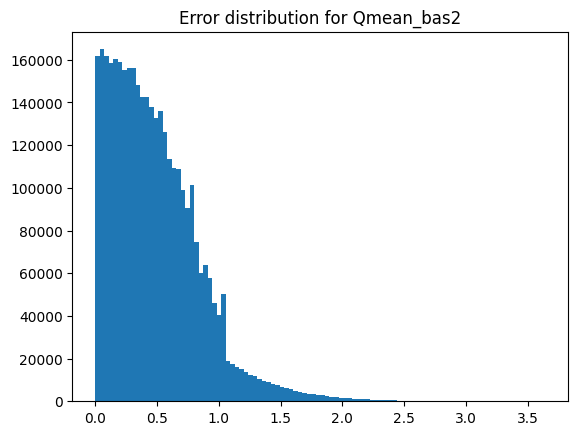

MAE:0.48531094193458557
MSE:0.3668741285800934
MAPE:4.375129699707031
Pearson correlation z-score vs Qmean_bas2 (exceptional):0.4953610769912905
Spearman correlation z-score vs Qmean_bas2 (exceptional):0.48849639322580884


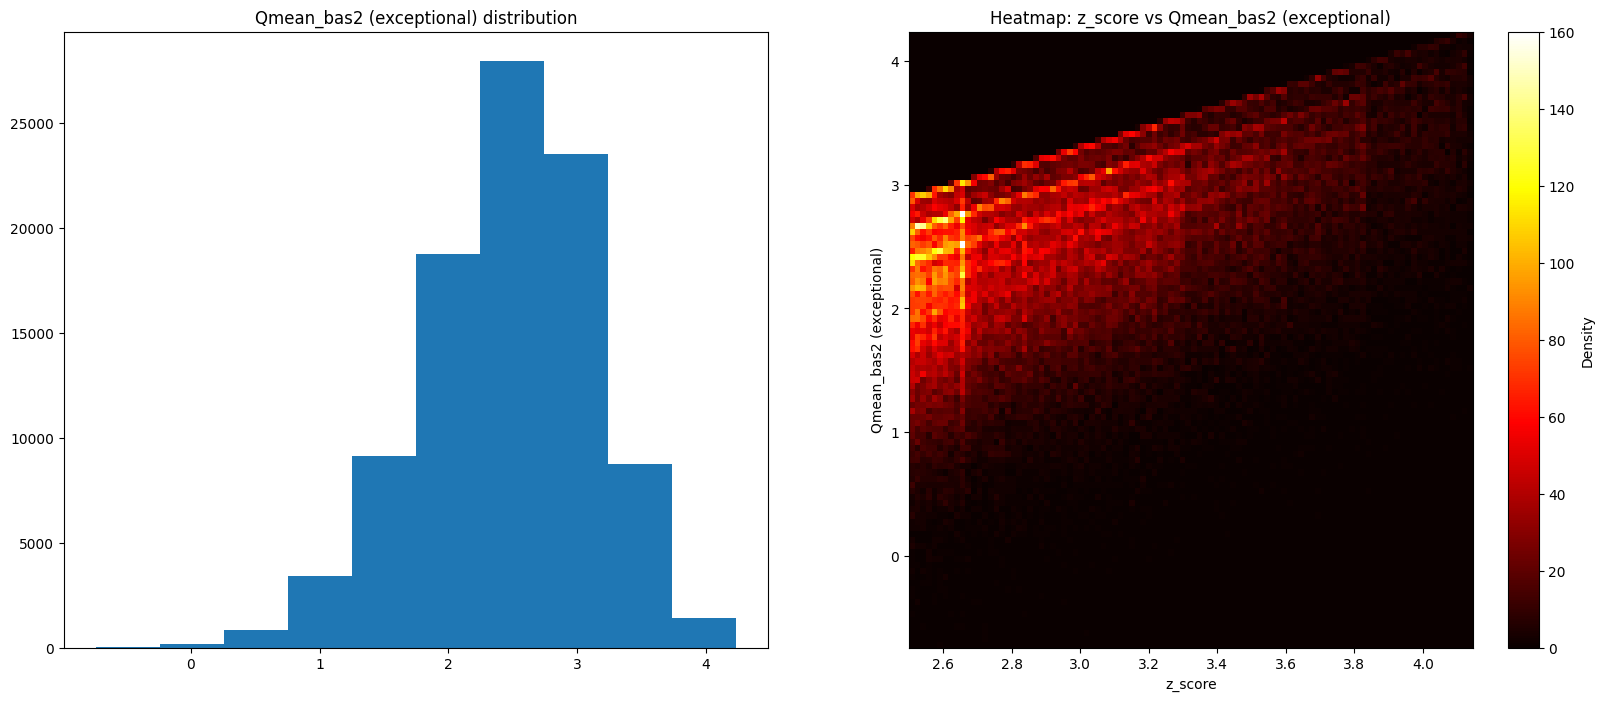

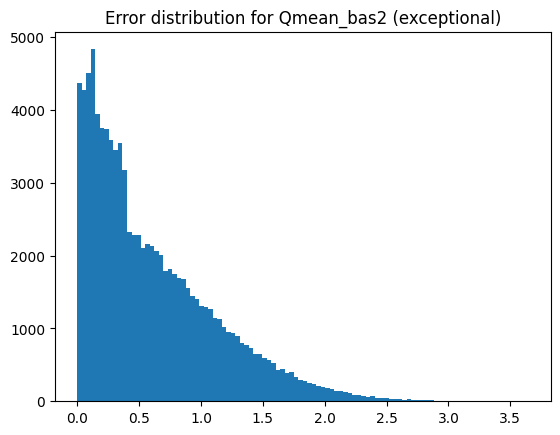

MAE:0.6107699275016785
MSE:0.6439340114593506
MAPE:0.20416469871997833
Pearson correlation z-score vs Qmean_bas3:0.8659950171212069
Spearman correlation z-score vs Qmean_bas3:0.8197341503121303


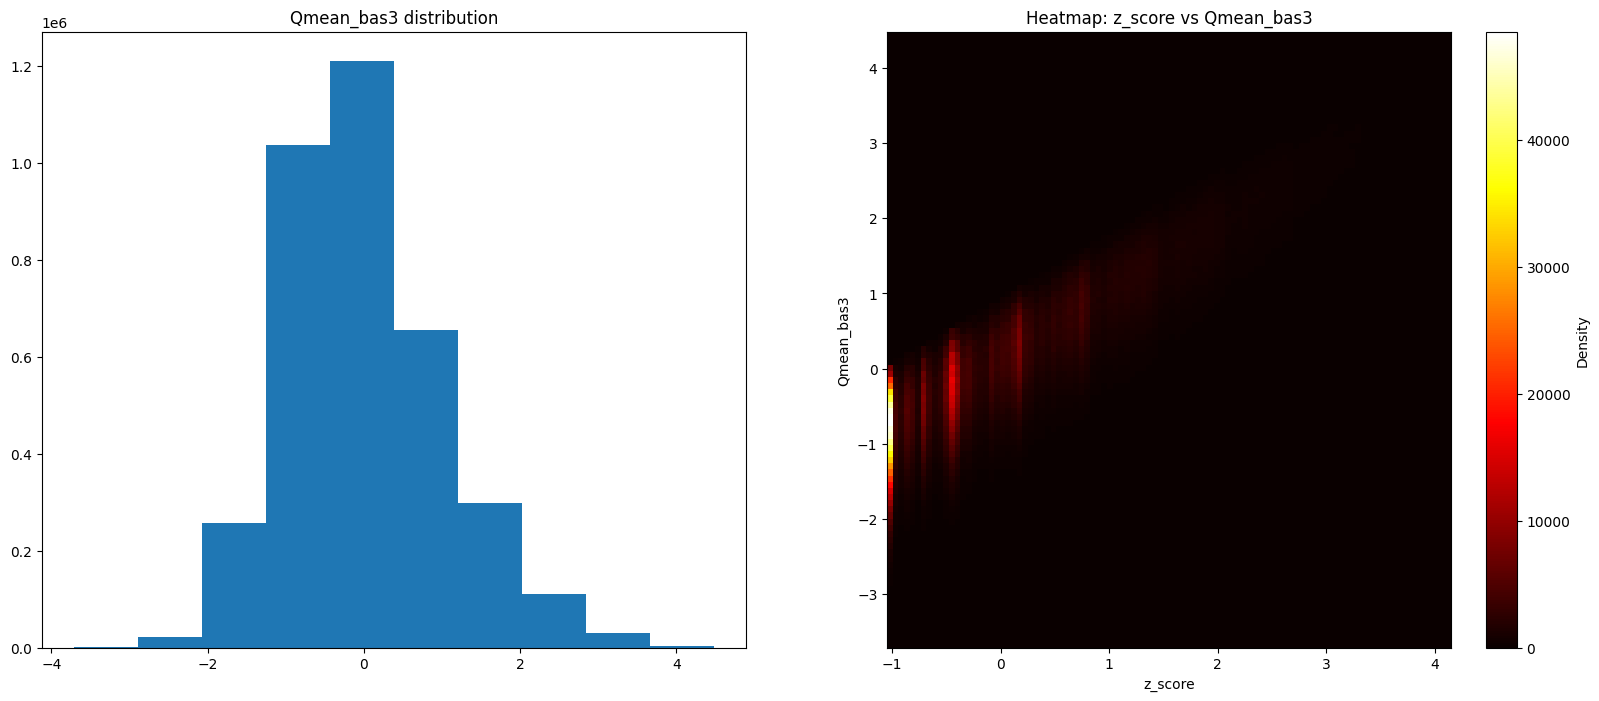

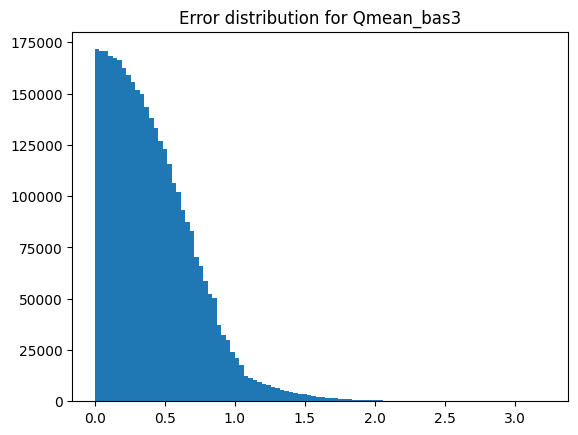

MAE:0.41469836235046387
MSE:0.26801005005836487
MAPE:4.162086486816406
Pearson correlation z-score vs Qmean_bas3 (exceptional):0.569260964904724
Spearman correlation z-score vs Qmean_bas3 (exceptional):0.5519785331358051


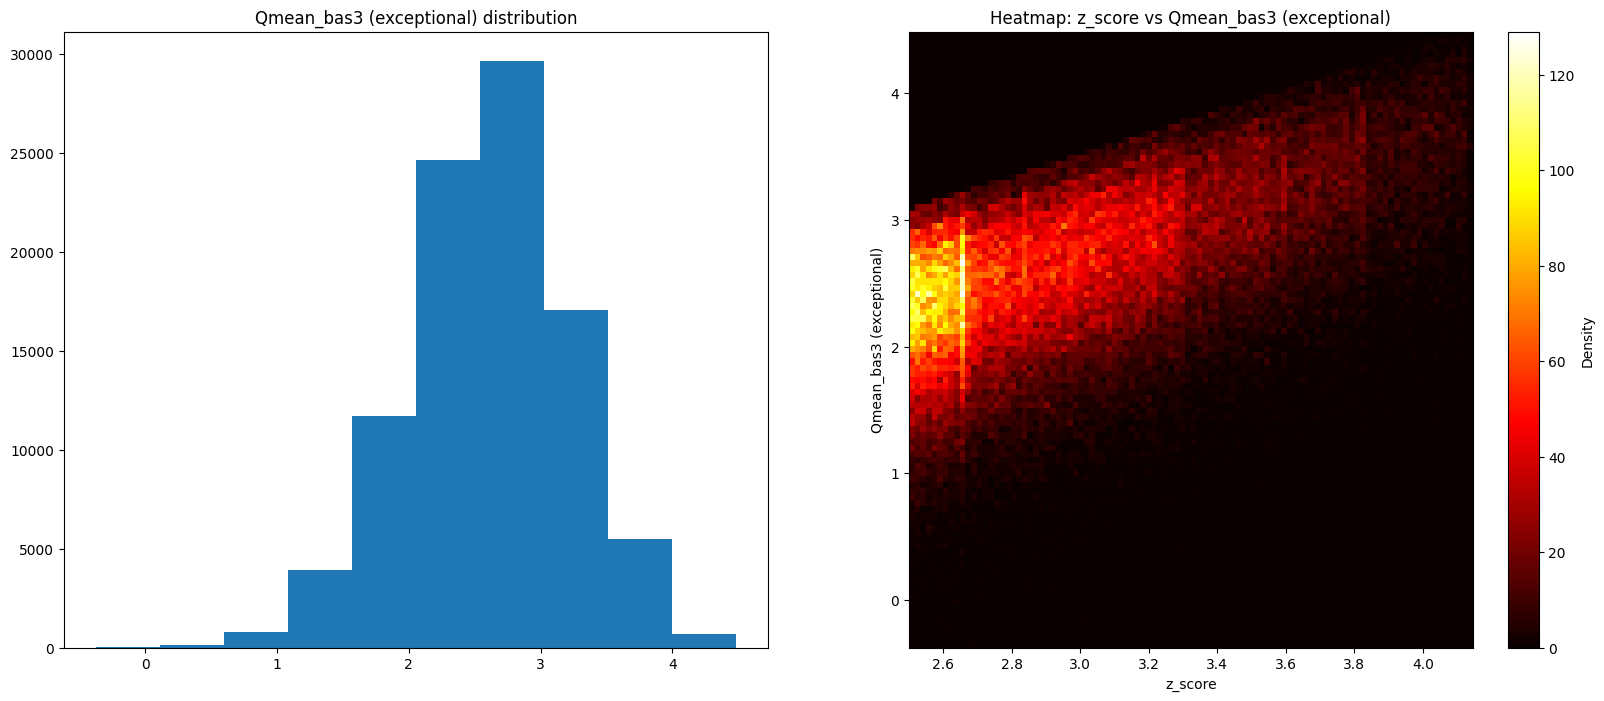

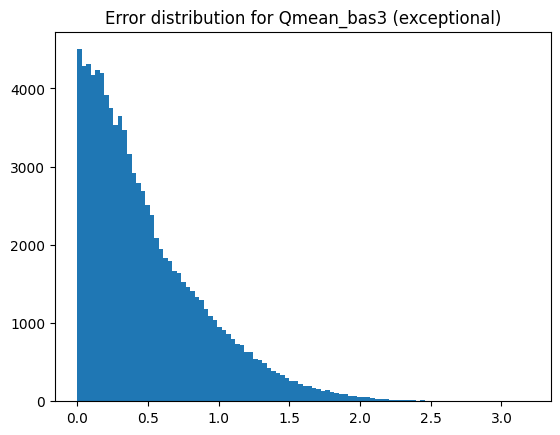

MAE:0.495064914226532
MSE:0.41759195923805237
MAPE:0.1658276468515396
Pearson correlation z-score vs Qmean_bas4:0.8944786264369633
Spearman correlation z-score vs Qmean_bas4:0.8509931231692865


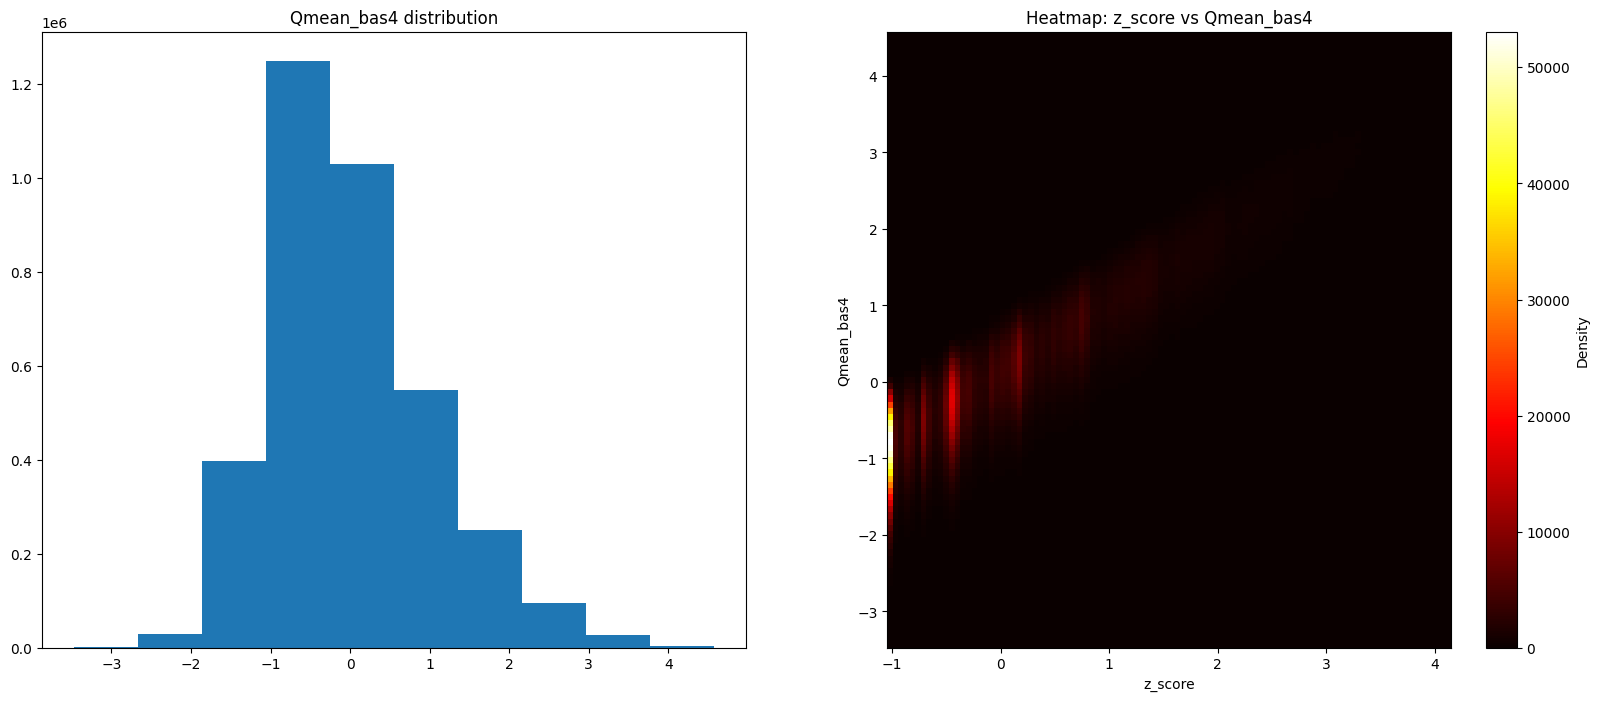

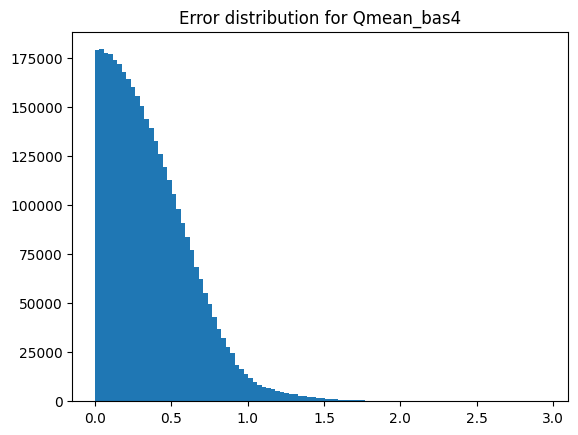

MAE:0.36765238642692566
MSE:0.21104279160499573
MAPE:3.0363662242889404
Pearson correlation z-score vs Qmean_bas4 (exceptional):0.6280271472605624
Spearman correlation z-score vs Qmean_bas4 (exceptional):0.6083562758457342


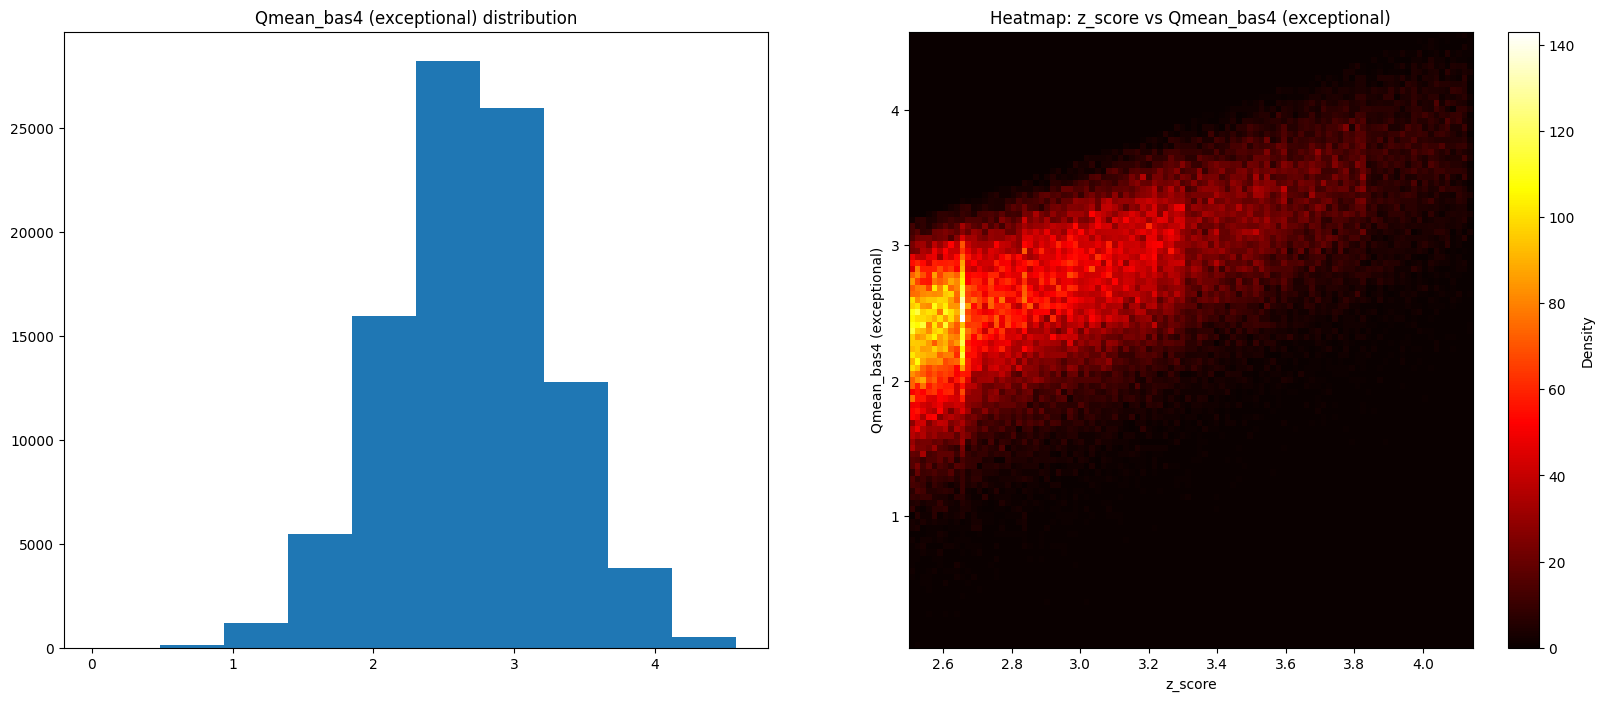

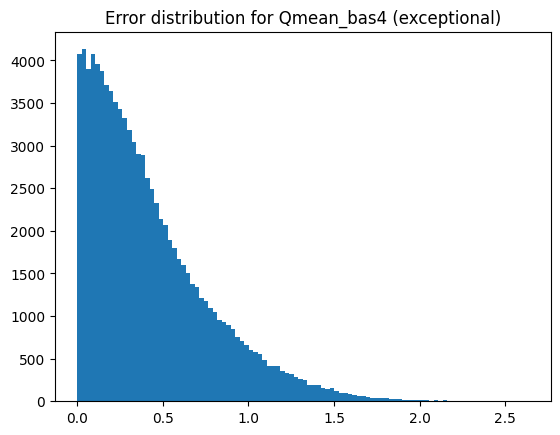

MAE:0.42456379532814026
MSE:0.3032188415527344
MAPE:0.14247086644172668
Pearson correlation z-score vs Qmean_bas5:0.9128822913799274
Spearman correlation z-score vs Qmean_bas5:0.872409508760926


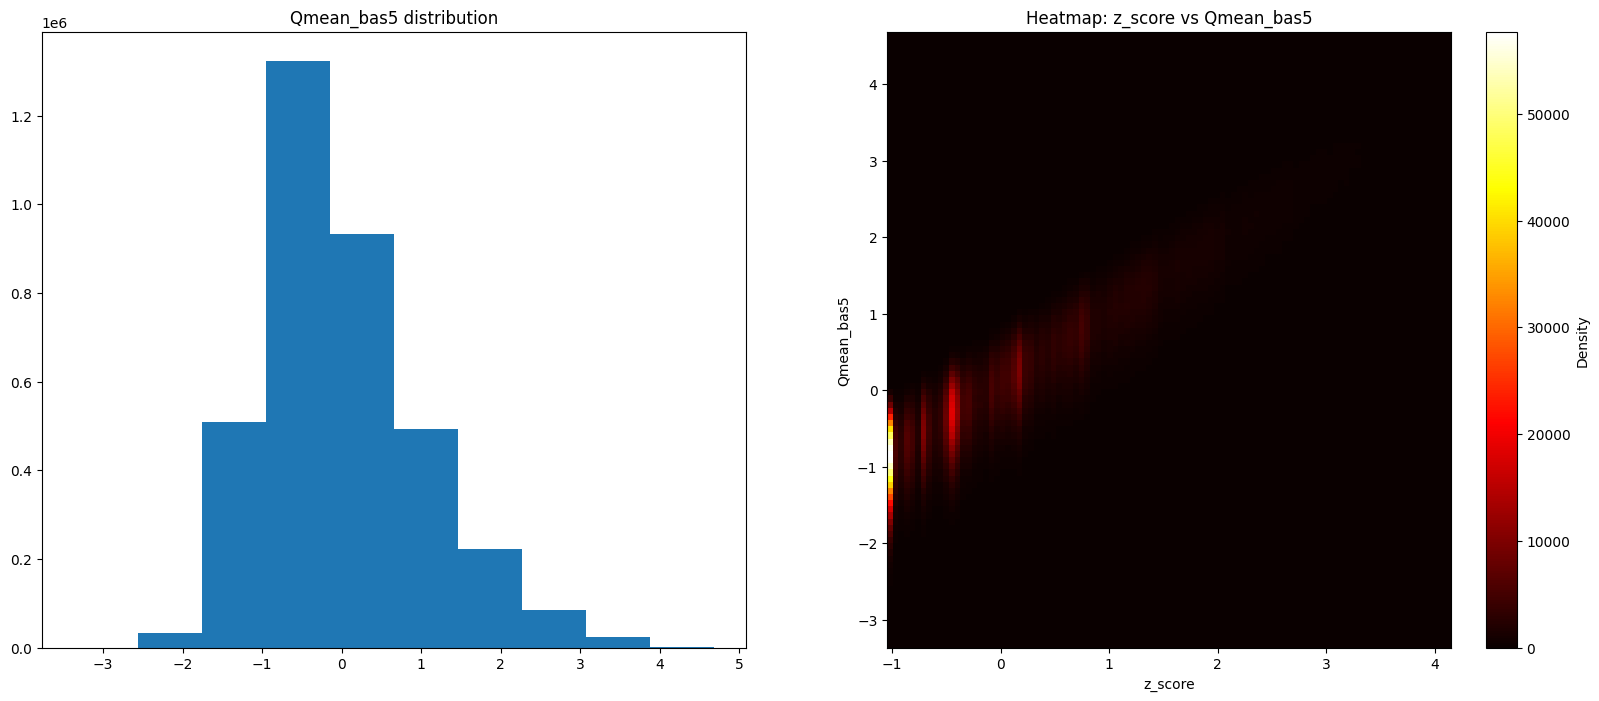

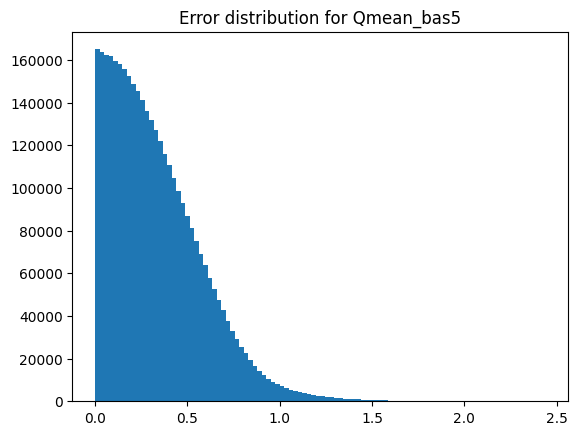

MAE:0.3339393436908722
MSE:0.17423535883426666
MAPE:2.7138023376464844
Pearson correlation z-score vs Qmean_bas5 (exceptional):0.67030824938263
Spearman correlation z-score vs Qmean_bas5 (exceptional):0.6498237447698029


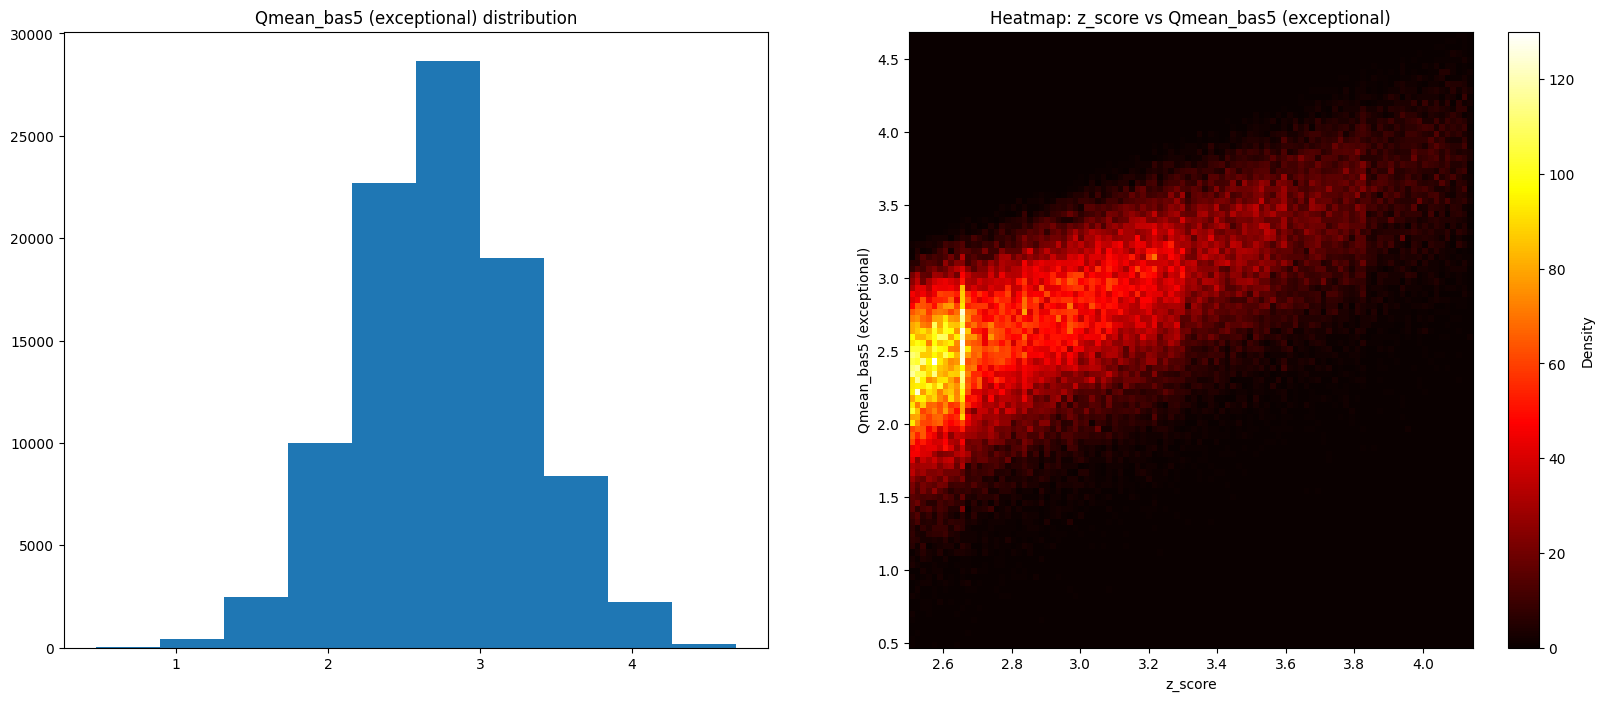

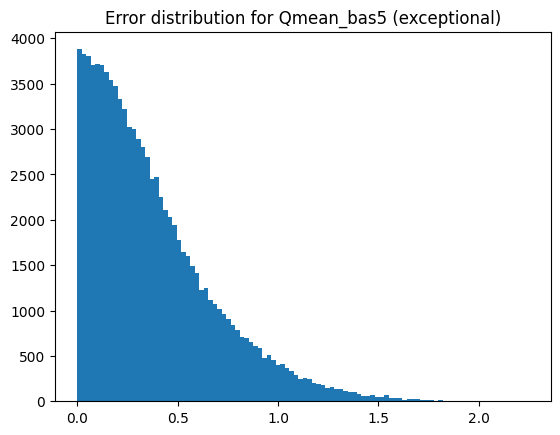

MAE:0.3766208589076996
MSE:0.23671342432498932
MAPE:0.12648308277130127
Pearson correlation z-score vs Qmean_bas6:0.9257015660570908
Spearman correlation z-score vs Qmean_bas6:0.8878725545035783


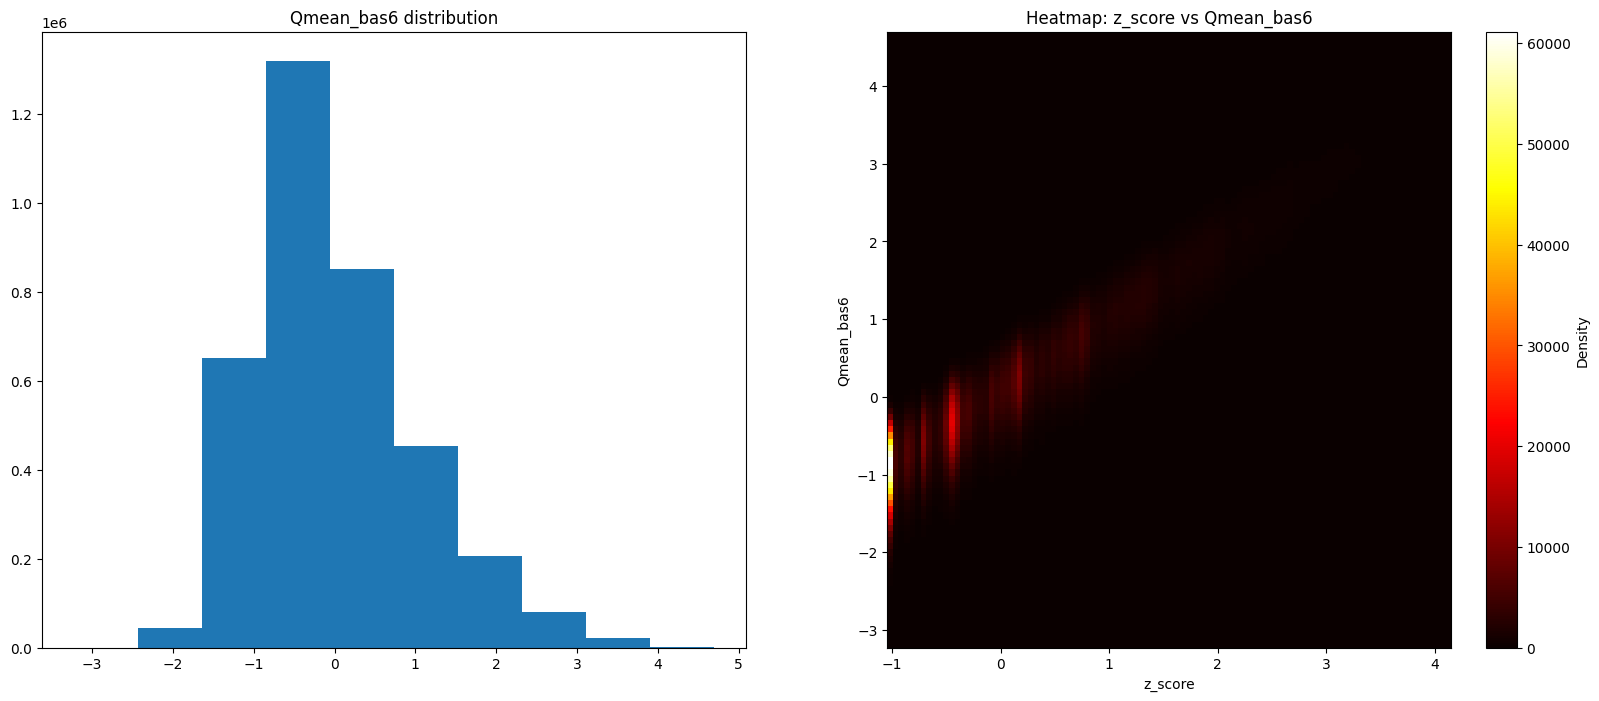

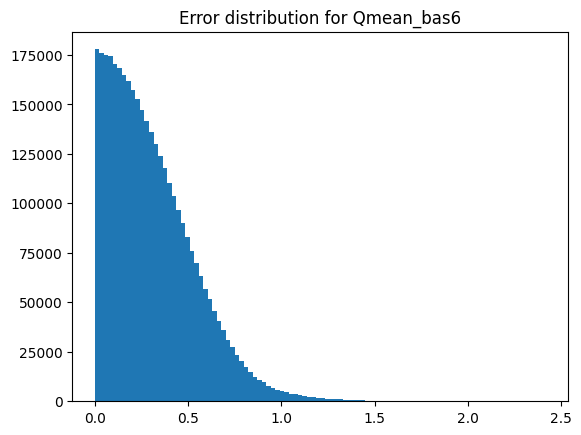

MAE:0.30824941396713257
MSE:0.1485968828201294
MAPE:2.2822396755218506
Pearson correlation z-score vs Qmean_bas6 (exceptional):0.6994407316773956
Spearman correlation z-score vs Qmean_bas6 (exceptional):0.6776724297569051


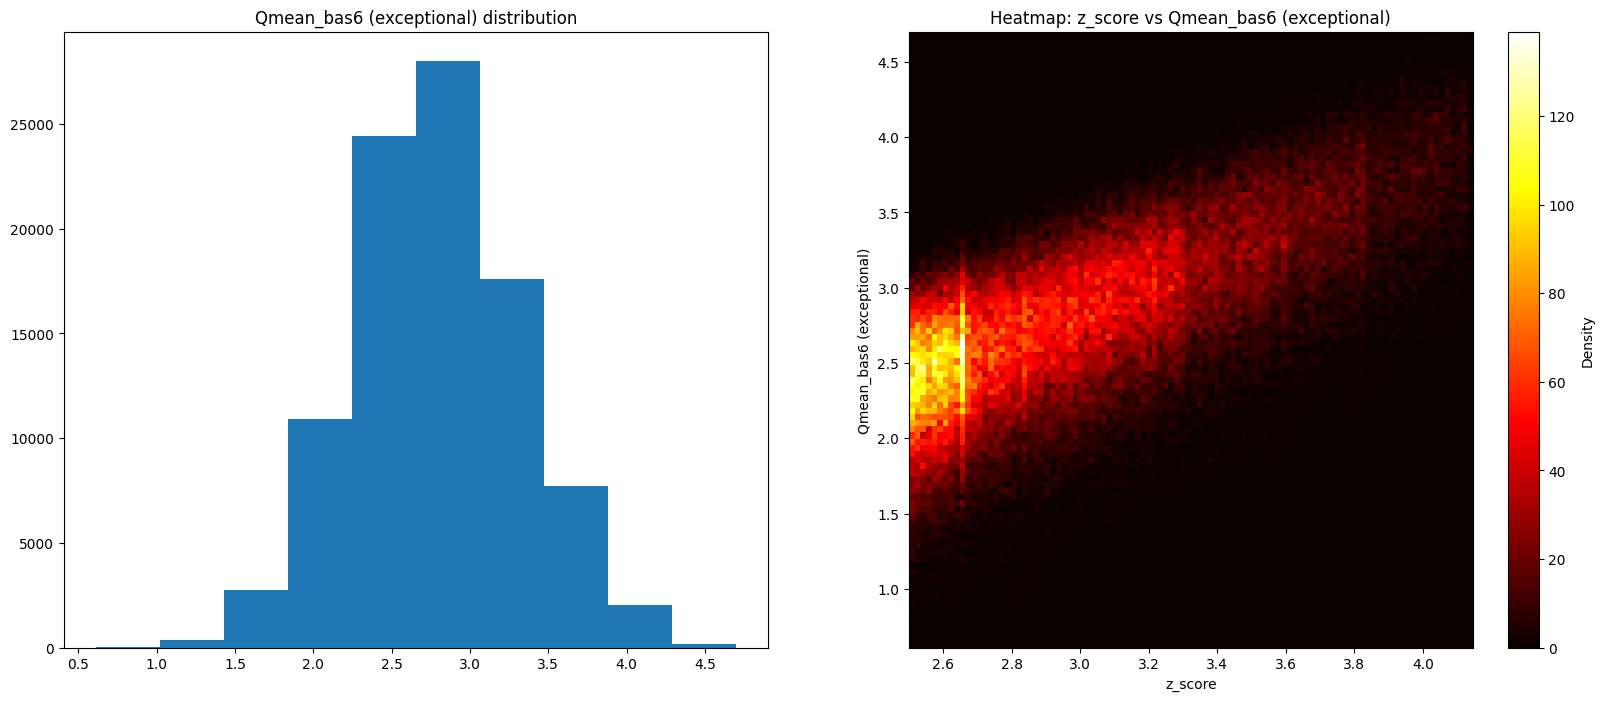

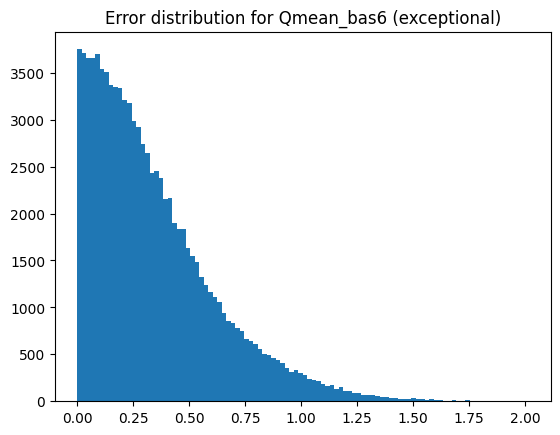

MAE:0.3433975875377655
MSE:0.19554992020130157
MAPE:0.11539040505886078
Pearson correlation z-score vs Qmean_bas7:0.9354342622214855
Spearman correlation z-score vs Qmean_bas7:0.8998084901842744


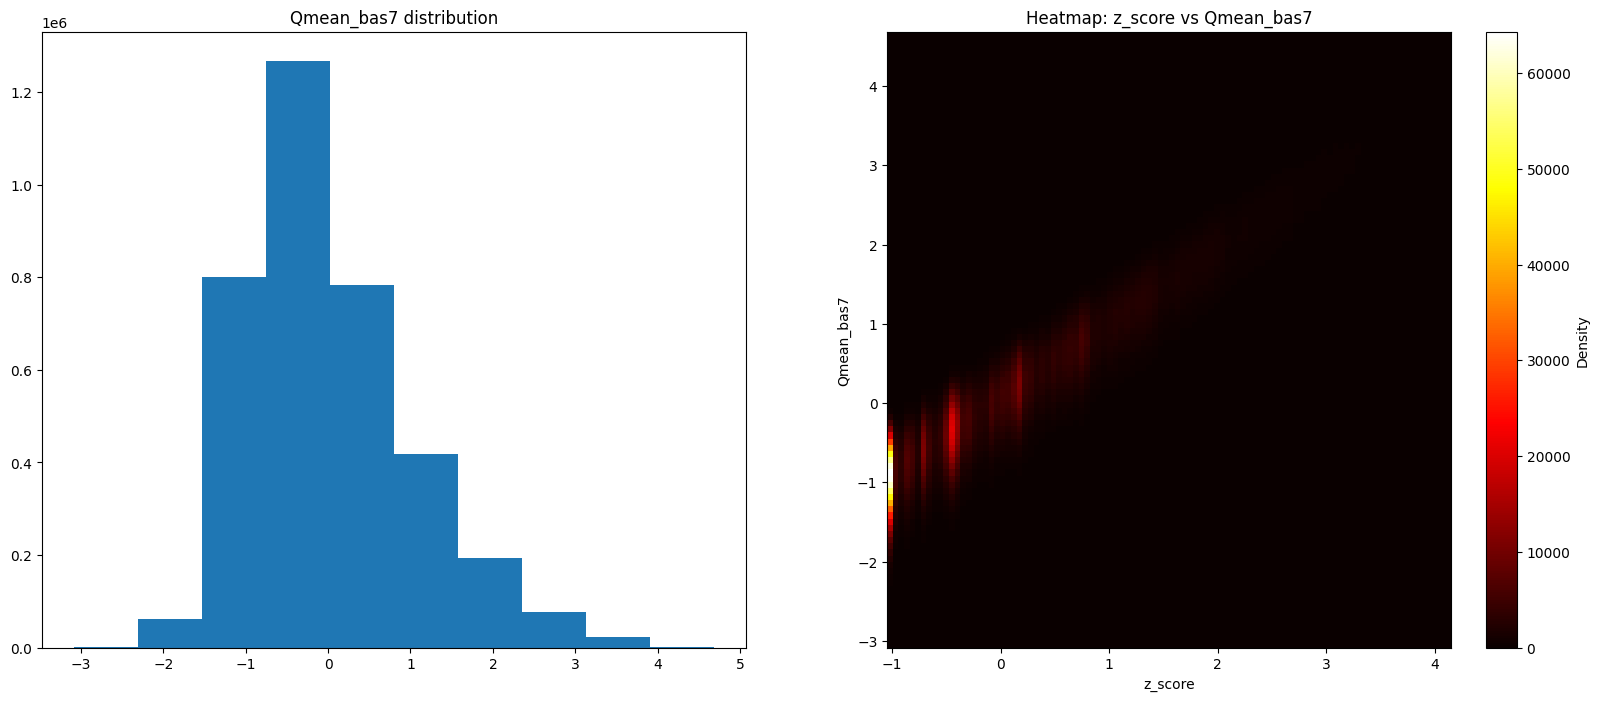

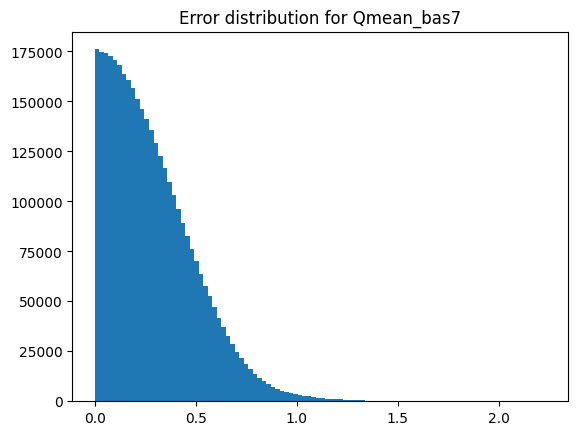

MAE:0.28726327419281006
MSE:0.1291314661502838
MAPE:2.2128775119781494
Pearson correlation z-score vs Qmean_bas7 (exceptional):0.7275414741752888
Spearman correlation z-score vs Qmean_bas7 (exceptional):0.7062263127190973


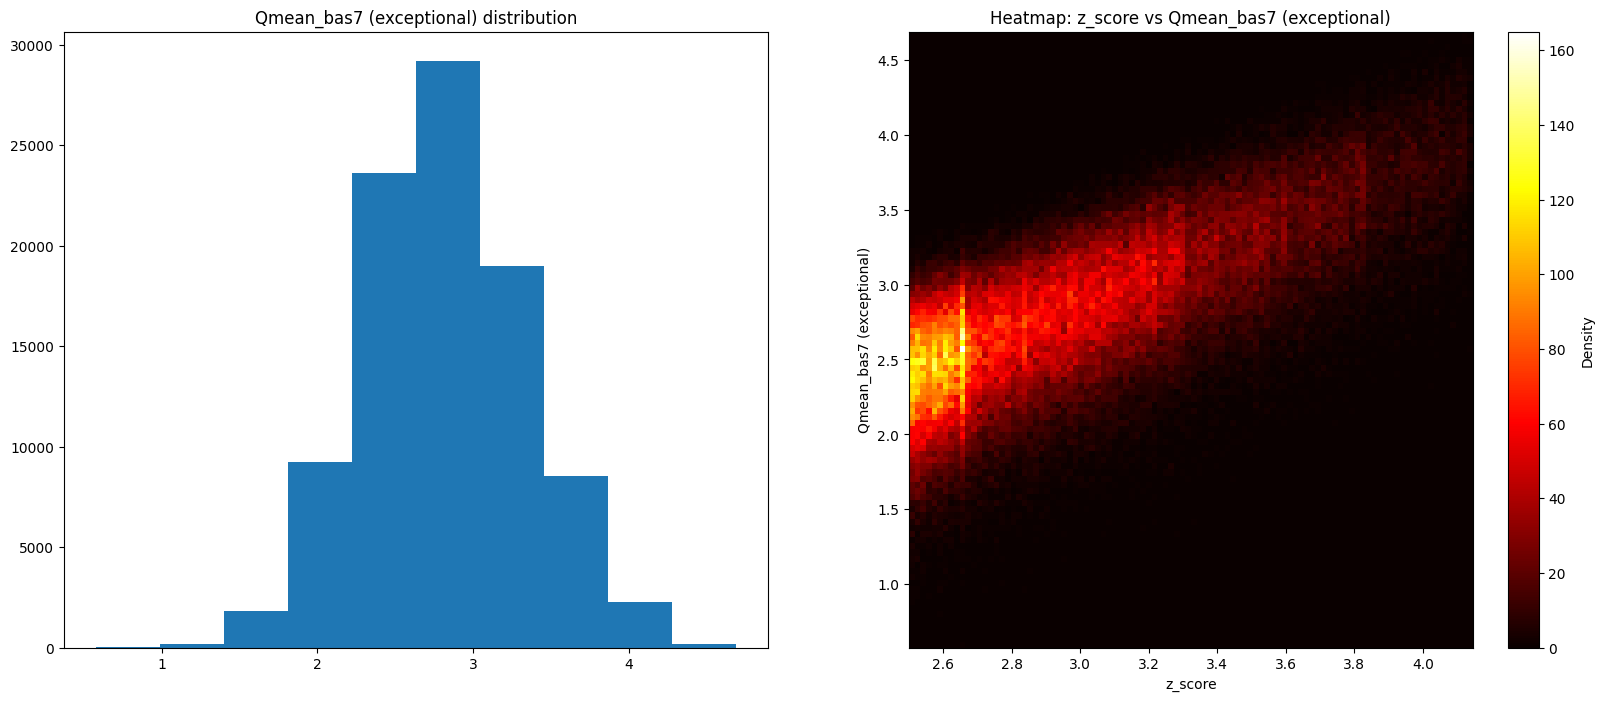

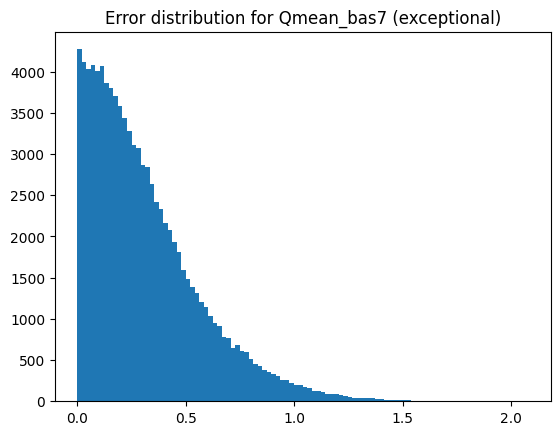

MAE:0.31506073474884033
MSE:0.1643611341714859
MAPE:0.10596134513616562
Pearson correlation z-score vs Qmean_bas8:0.9427524417191839
Spearman correlation z-score vs Qmean_bas8:0.9091345813660849


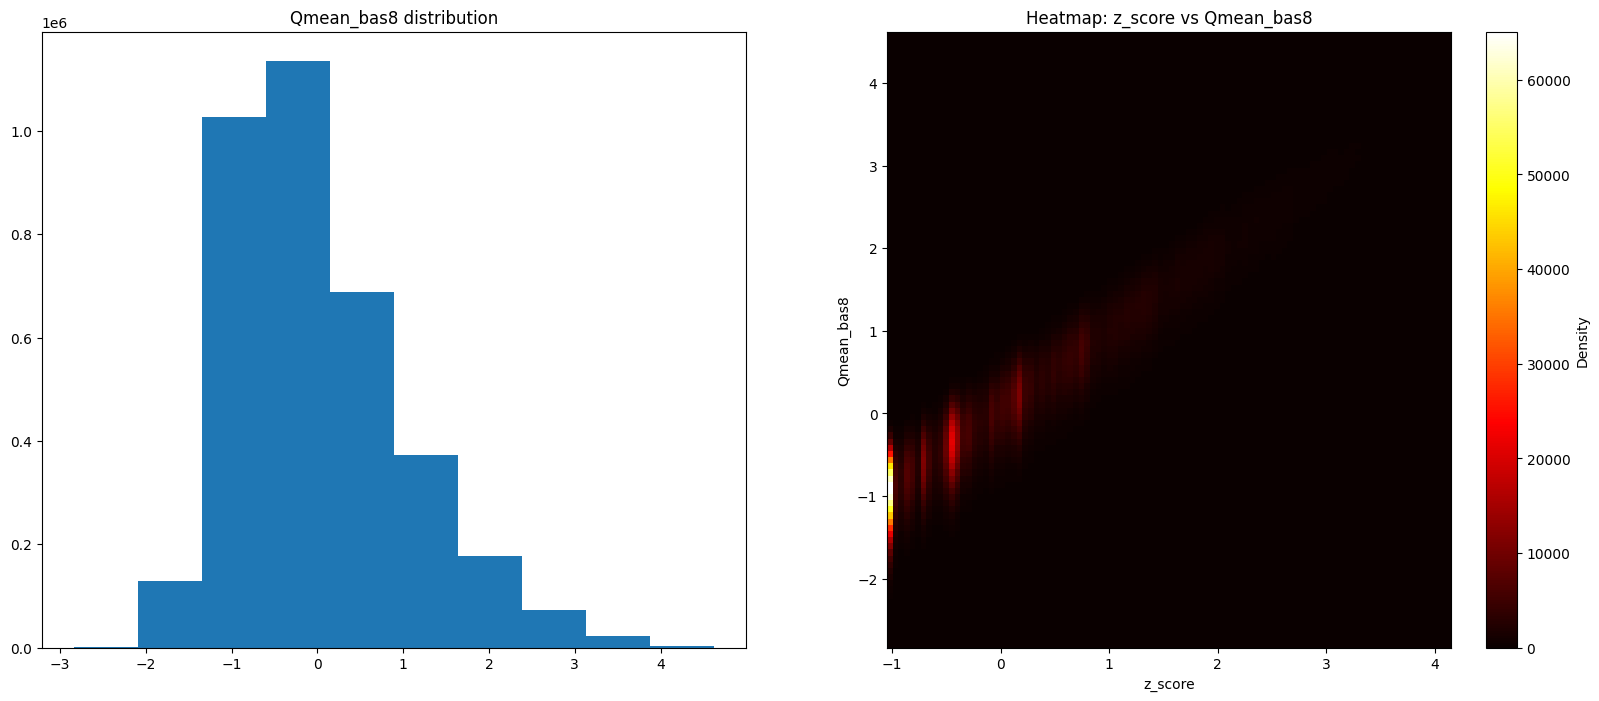

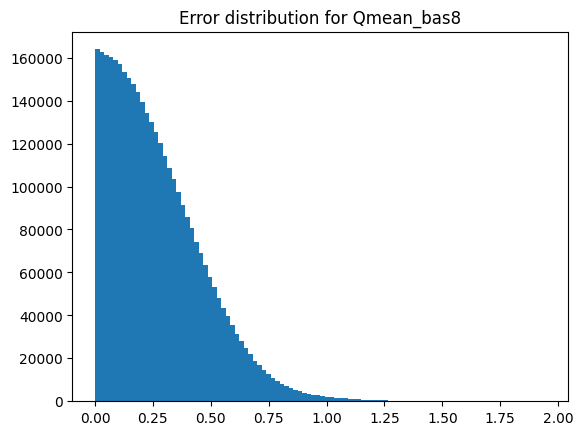

MAE:0.2704527974128723
MSE:0.11449510604143143
MAPE:2.1733787059783936
Pearson correlation z-score vs Qmean_bas8 (exceptional):0.7496587342460805
Spearman correlation z-score vs Qmean_bas8 (exceptional):0.7270267931181179


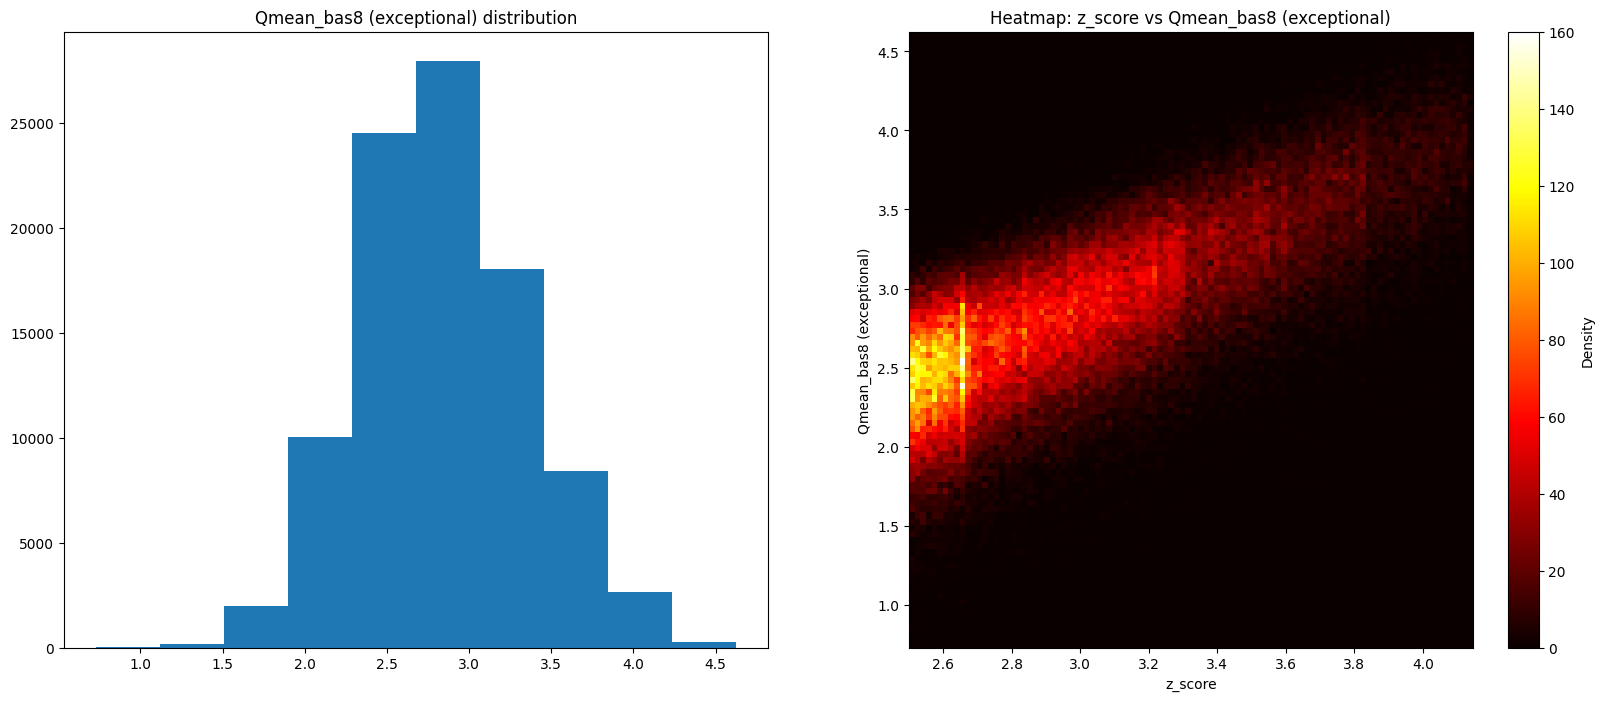

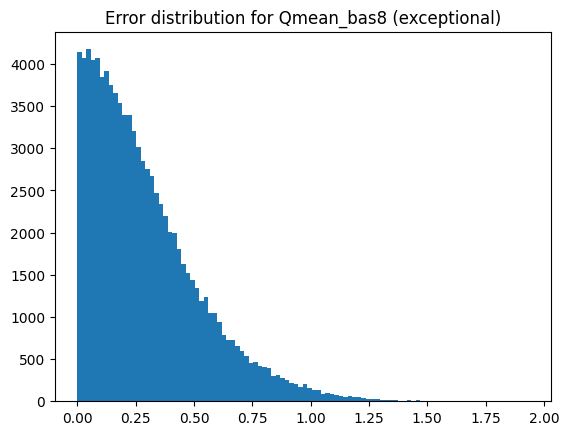

MAE:0.2934839129447937
MSE:0.14176705479621887
MAPE:0.09869100898504257
Pearson correlation z-score vs Qmean_bas9:0.9486132371173074
Spearman correlation z-score vs Qmean_bas9:0.9167457874911364


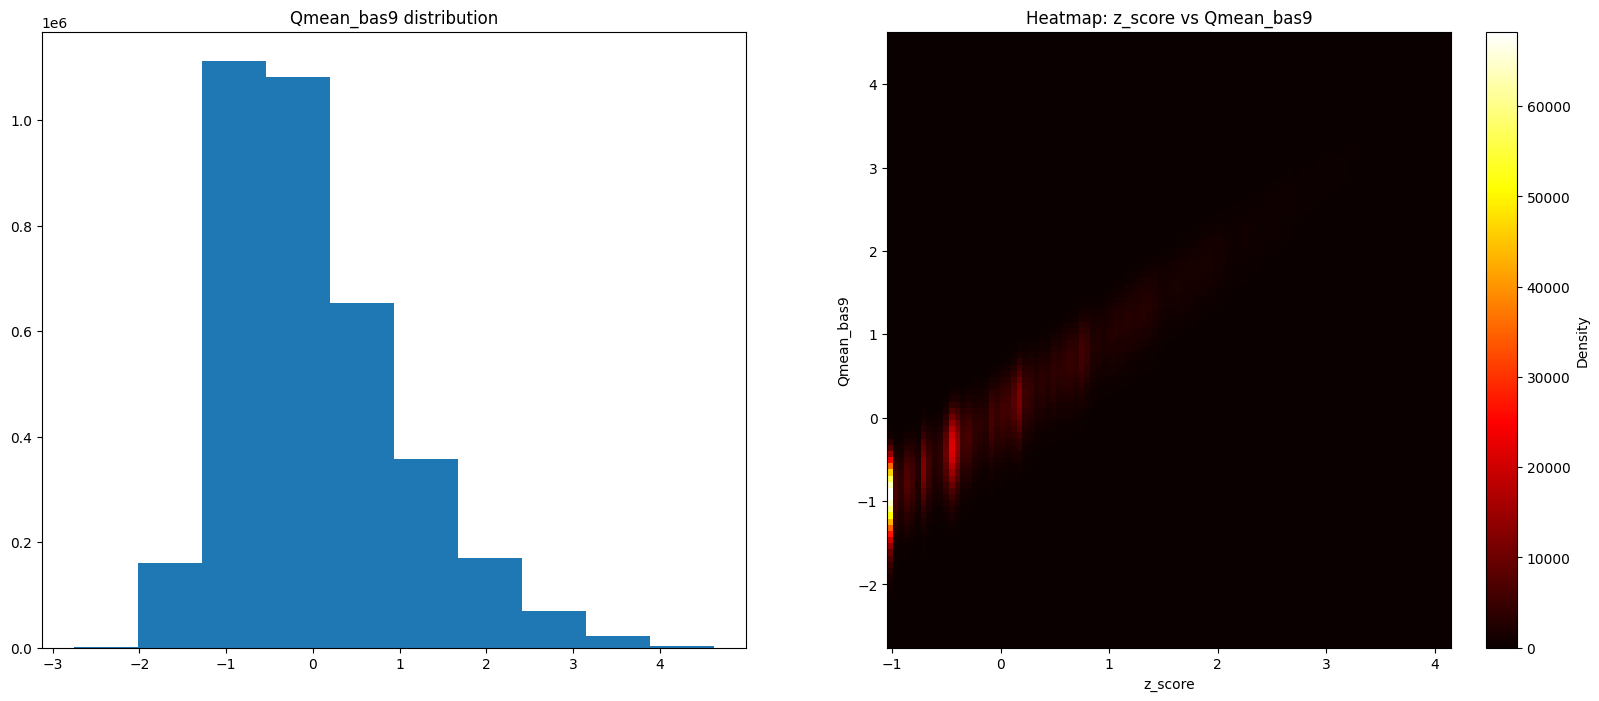

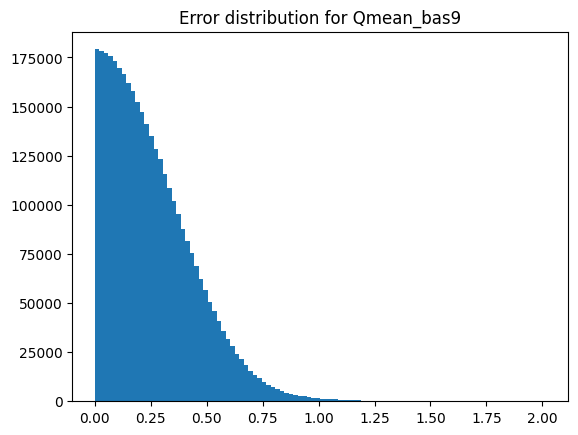

MAE:0.2561591863632202
MSE:0.10277348756790161
MAPE:2.334622383117676
Pearson correlation z-score vs Qmean_bas9 (exceptional):0.7707626882910118
Spearman correlation z-score vs Qmean_bas9 (exceptional):0.7471385391282067


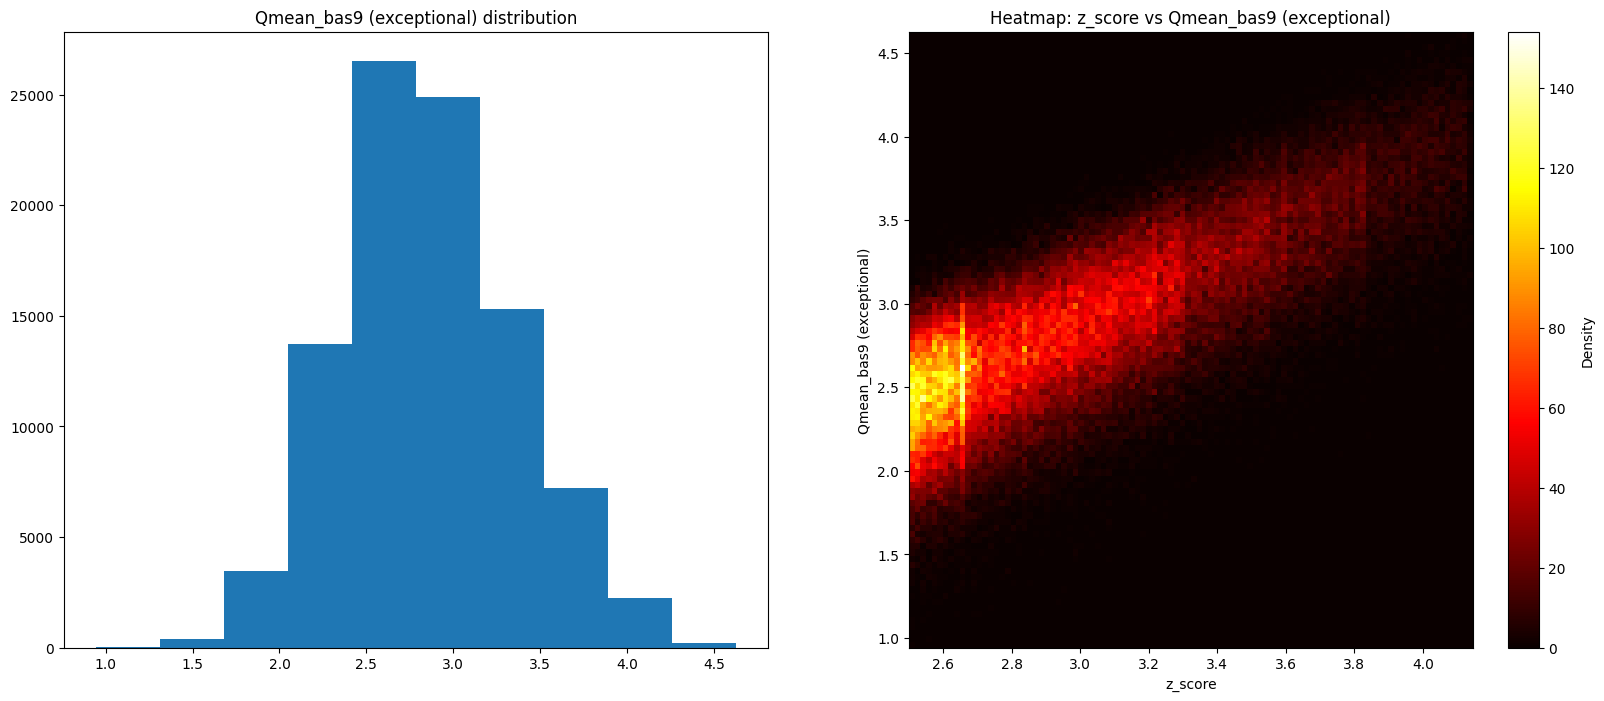

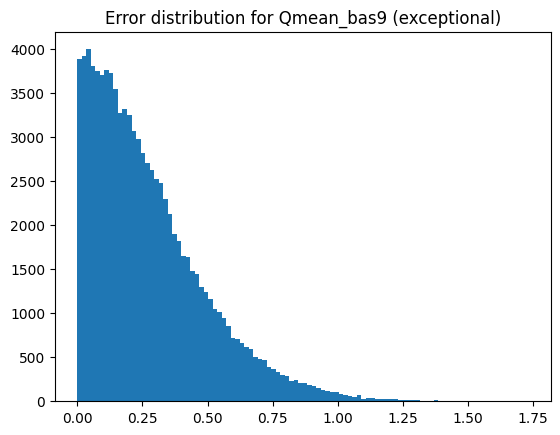

MAE:0.27603399753570557
MSE:0.12483177334070206
MAPE:0.09292702376842499
Pearson correlation z-score vs Qmean_bas10:0.9534500755387854
Spearman correlation z-score vs Qmean_bas10:0.9230223236692034


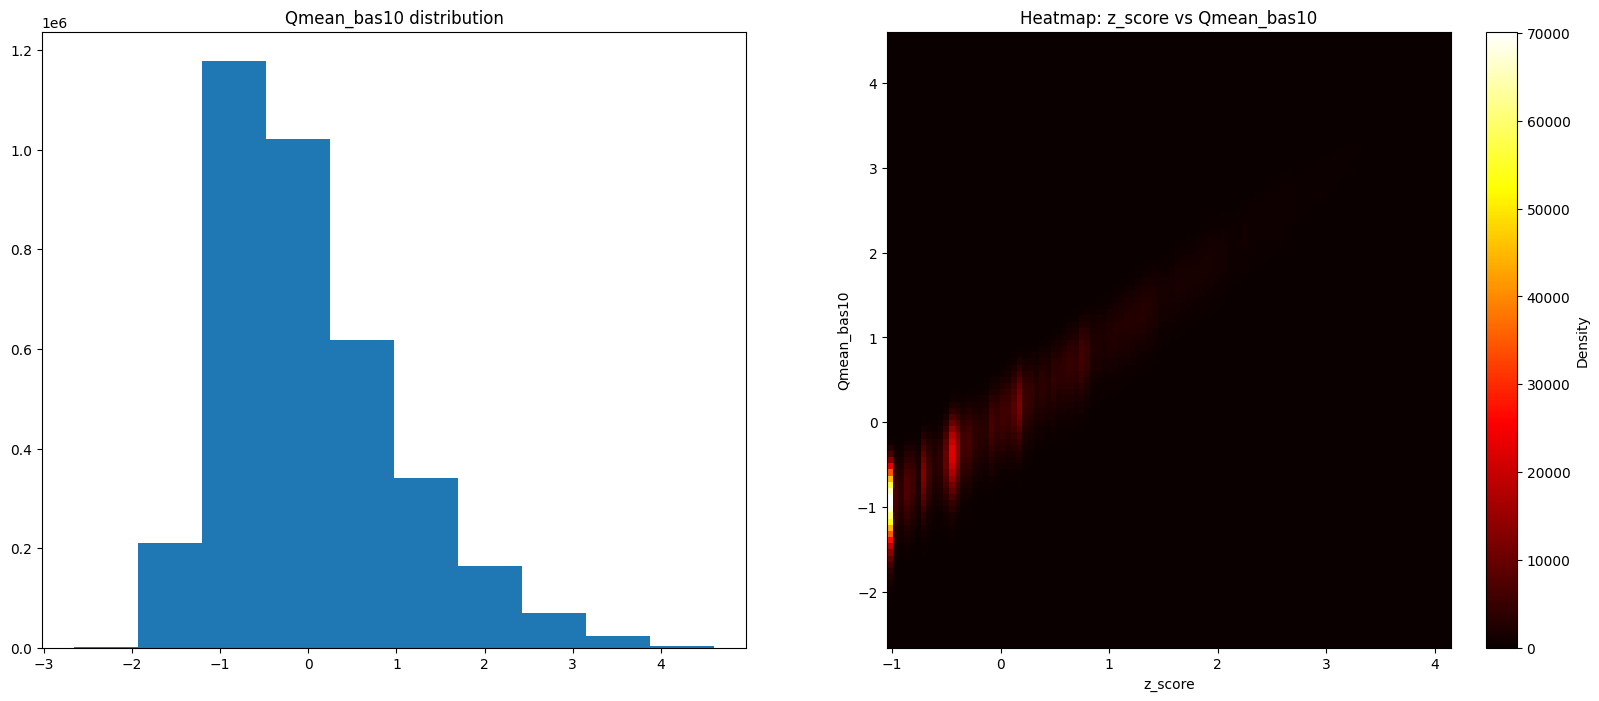

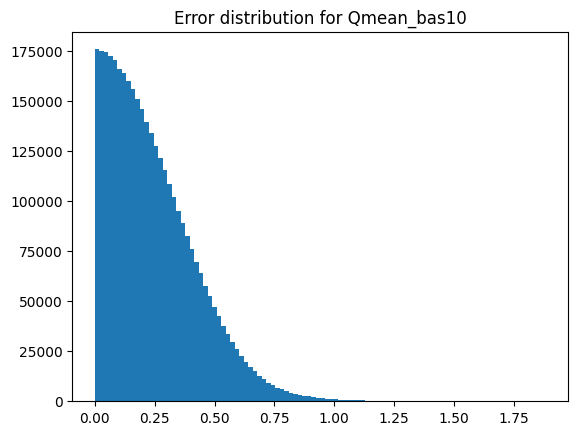

MAE:0.2438586801290512
MSE:0.09309983998537064
MAPE:1.916337251663208
Pearson correlation z-score vs Qmean_bas10 (exceptional):0.7867986756917499
Spearman correlation z-score vs Qmean_bas10 (exceptional):0.7651873521893496


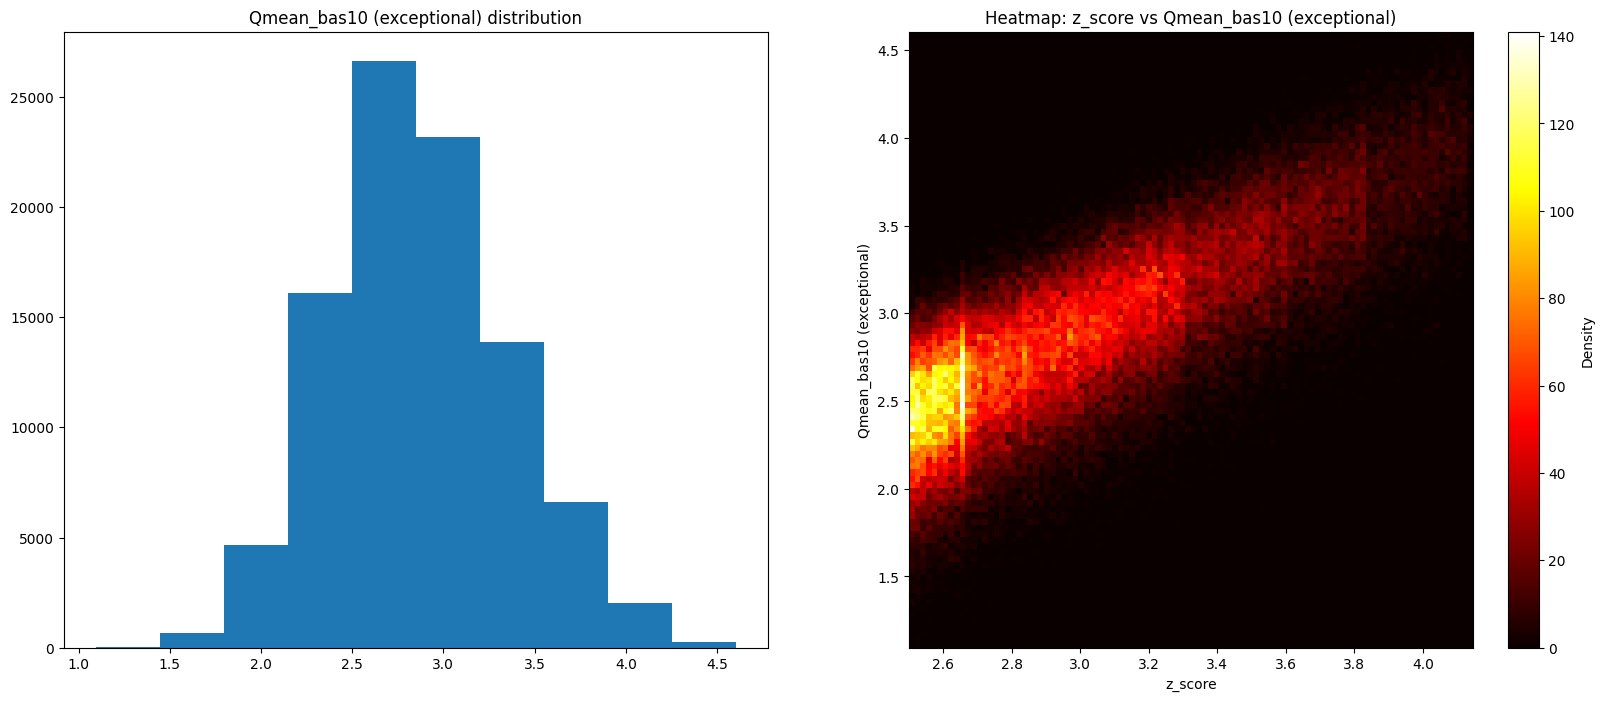

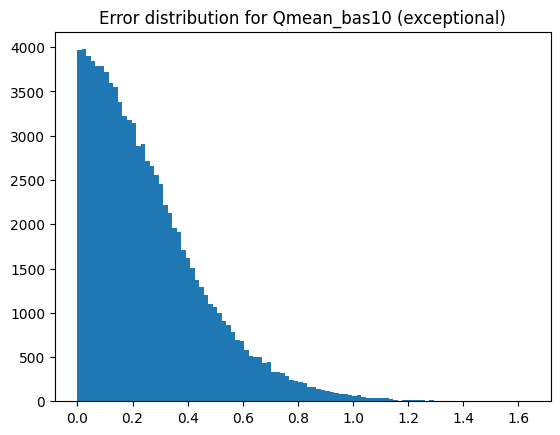

MAE:0.2598133981227875
MSE:0.1106136217713356
MAPE:0.08744284510612488


In [137]:
def compute_qbas(measure, num_samples):
    random_indices = np.random.randint(0,  measure.shape[0], (measure.shape[0], num_samples))
    random_qmeans = measure[random_indices]
    mean = np.mean(random_qmeans, axis=1)

    # First way to deal with std==0; add some epsilon
    #std = np.std(random_qmeans, axis=1) + 1e-10

    # Second way to deal with std==0; ignore std (divide by 1)
    std = np.std(random_qmeans, axis=1)
    std[std==0] = 1

    # Always ignore std
    std=1
    return (measure - mean) / std

qbas_results = []
qbas_results_exceptional = []

## Computing Qmean_basX
for i in range(2,11):
    # Take two random indices for each sample
    qmean_basX = compute_qbas(qmeans.flatten(), i)
    qmean_basX = (qmean_basX -  np.mean(qmean_basX)) / np.std(qmean_basX)
    qbas_results.append(show_performance(z_scores, qmean_basX, f'Qmean_bas{i}'))
    qbas_results_exceptional.append(show_performance(z_scores[exceptional_indices], qmean_basX[exceptional_indices], f'Qmean_bas{i} (exceptional)'))

### Result summary

In [127]:
from tqdm import tqdm
qmean_basX_meanstds = []
qmean_basX_exceptional_meanstds = []
for n_samples in range(2,11):
    qmean_basX_results = []
    qmean_basX_exceptional_results = []
    for i in range(20):
        qmean_basX = compute_qbas(qmeans.flatten(), n_samples)
        estimator_standard = (qmean_basX - np.mean(qmean_basX))/np.std(qmean_basX)
        qmean_basX_results.append(mean_absolute_percentage_error(z_scores,estimator_standard))
        estimator_standard = estimator_standard[exceptional_indices]
        qmean_basX_exceptional_results.append(mean_absolute_percentage_error(z_scores[exceptional_indices],estimator_standard))
    mean = np.mean(qmean_basX_results)
    std = np.std(qmean_basX_results)
    print(f'{n_samples} samples: {mean} (+-{std}) MAPE')
    qmean_basX_meanstds.append((mean,std))

    mean = np.mean(qmean_basX_exceptional_results)
    std = np.std(qmean_basX_exceptional_results)
    print(f'{n_samples} samples (exceptional): {mean} (+-{std}) MAPE')
    qmean_basX_exceptional_meanstds.append((mean,std))

2 samples: 3.7389957904815674 (+-0.2315688282251358) MAPE
2 samples (exceptional): 0.20418477058410645 (+-0.00044804546632803977) MAPE
3 samples: 3.237783908843994 (+-0.2552836239337921) MAPE
3 samples (exceptional): 0.1655901074409485 (+-0.0004987489082850516) MAPE
4 samples: 2.929927349090576 (+-0.24252444505691528) MAPE
4 samples (exceptional): 0.14236940443515778 (+-0.00040399283170700073) MAPE
5 samples: 2.5923452377319336 (+-0.2149217426776886) MAPE
5 samples (exceptional): 0.12655195593833923 (+-0.00027220978518016636) MAPE
6 samples: 2.392881393432617 (+-0.17147225141525269) MAPE
6 samples (exceptional): 0.11472468078136444 (+-0.0002977487165480852) MAPE
7 samples: 2.242110252380371 (+-0.1703597605228424) MAPE
7 samples (exceptional): 0.1057933121919632 (+-0.00022167593124322593) MAPE
8 samples: 2.1291279792785645 (+-0.16932956874370575) MAPE
8 samples (exceptional): 0.09854776412248611 (+-0.0002823256654664874) MAPE
9 samples: 2.0325703620910645 (+-0.11707070469856262) MAPE
9 

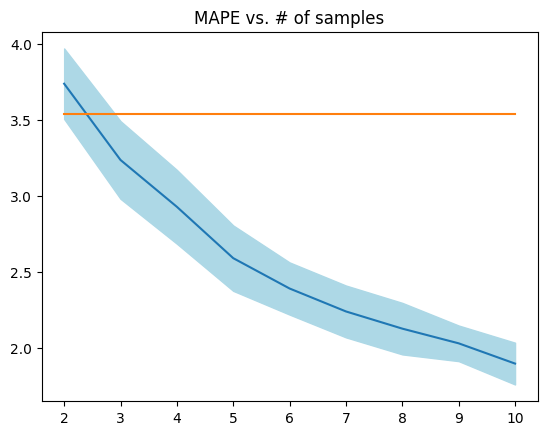

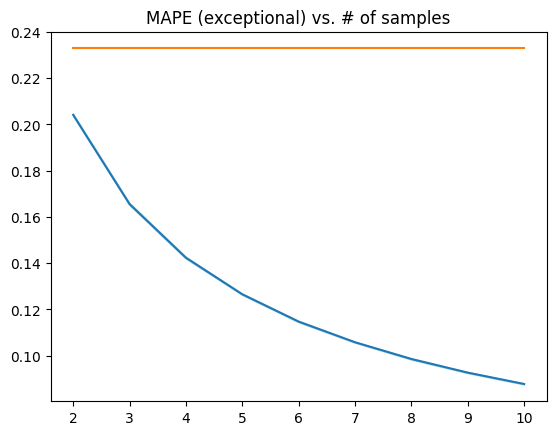

In [130]:
plt.fill_between(range(2,11),[x+y for x,y in qmean_basX_meanstds],[x-y for x,y in qmean_basX_meanstds], color='lightblue')
plt.plot(range(2,11),[x for x,y in qmean_basX_meanstds])
plt.title('MAPE vs. # of samples')
plt.plot([2,10],[qinv_results[3],qinv_results[3]])
plt.show()

plt.fill_between(range(2,11),[x+y for x,y in qmean_basX_exceptional_meanstds],[x-y for x,y in qmean_basX_exceptional_meanstds], color='lightblue')
plt.plot(range(2,11),[x for x,y in qmean_basX_exceptional_meanstds])
plt.title('MAPE (exceptional) vs. # of samples')
plt.plot([2,10],[qinv_results_exceptional[3],qinv_results_exceptional[3]])
plt.show()

In [141]:
import pandas as pd
rows = []
names = ['qbas1']
rows.append(dict((l,x) for (l,x) in zip(['pearson','spearman','mae','mse','mape'],qmean_results)) | dict((l,x) for (l,x) in zip(['pearson_exceptional','spearman_exceptional','mae_exceptional','mse_exceptional','mape_exceptional'],qmean_results_exceptional)))
i=2
for qbas_result, qbas_result_exceptional in zip(qbas_results, qbas_results_exceptional):
    names.append(f'qbas{i}')
    rows.append(dict((l,x) for (l,x) in zip(['pearson','spearman','mae','mse','mape'],qbas_result)) | dict((l,x) for (l,x) in zip(['pearson_exceptional','spearman_exceptional','mae_exceptional','mse_exceptional','mape_exceptional'],qbas_result_exceptional)))
    i+=1
names.append('qinv')
rows.append(dict((l,x) for (l,x) in zip(['pearson','spearman','mae','mse','mape'],qinv_results)) | dict((l,x) for (l,x) in zip(['pearson_exceptional','spearman_exceptional','mae_exceptional','mse_exceptional','mape_exceptional'],qinv_results_exceptional)))

print(rows)

df = pd.DataFrame.from_records(rows, index=names)
print(df)

[{'pearson': 0.707436898161421, 'spearman': 0.6758473617988408, 'mae': 0.60935944, 'mse': 0.585126, 'mape': 5.199805, 'pearson_exceptional': 0.3717511497513567, 'spearman_exceptional': 0.39908547281293444, 'mae_exceptional': 0.8824515, 'mse_exceptional': 1.294897, 'mape_exceptional': 0.29296228}, {'pearson': 0.8165629104478506, 'spearman': 0.769089655033795, 'mae': 0.48531094, 'mse': 0.36687413, 'mape': 4.3751297, 'pearson_exceptional': 0.4953610769912905, 'spearman_exceptional': 0.48849639322580884, 'mae_exceptional': 0.6107699, 'mse_exceptional': 0.643934, 'mape_exceptional': 0.2041647}, {'pearson': 0.8659950171212069, 'spearman': 0.8197341503121303, 'mae': 0.41469836, 'mse': 0.26801005, 'mape': 4.1620865, 'pearson_exceptional': 0.569260964904724, 'spearman_exceptional': 0.5519785331358051, 'mae_exceptional': 0.4950649, 'mse_exceptional': 0.41759196, 'mape_exceptional': 0.16582765}, {'pearson': 0.8944786264369633, 'spearman': 0.8509931231692865, 'mae': 0.3676524, 'mse': 0.21104279, '

Probably a good way to show this is plotting for different thresholds of exceptionality:
 - AUC (ability to detect such exceptional items)
 - Spearman correlation inside that set (ability to rank them accurately)

 Do that for several datasets (instances from avila) and compute means & stds.

 MAE, MSE & MAPE are misleading due to the different scale of the estimators. Attempts to transform them to the same scale are tricky and introduce artifacts and, importantly, **are not necessary** since what we care about is ranking, i.e. knowing whether one explanation is better than another.

In [133]:
# Medidas como detección
target = np.zeros_like(z_scores, dtype=int)
target[exceptional_indices] = 1

from sklearn import metrics
print('Inv:',metrics.roc_auc_score(target, qmean_invs),'AUC')
print('1 sample:',metrics.roc_auc_score(target, qmeans_bas),'AUC')

qmean_basX_meanstds = []
for n_samples in range(2,11):
    qmean_basX_results = []
    qmean_basX_exceptional_results = []
    for i in range(20):
        qmean_basX = compute_qbas(qmeans.flatten(), n_samples)
        estimator_standard = (qmean_basX - np.mean(qmean_basX))/np.std(qmean_basX)
        qmean_basX_results.append((metrics.roc_auc_score(target, estimator_standard)))
    mean = np.mean(qmean_basX_results)
    std = np.std(qmean_basX_results)
    print(f'{n_samples} samples: {mean} (+-{std}) AUC')
    qmean_basX_meanstds.append((mean,std))


0.9596702935441725
0.9978983297385668
2 samples: 0.9824063214940584 (+-0.0001312739603407985) AUC
3 samples: 0.9888762989195407 (+-9.708007899398137e-05) AUC
4 samples: 0.9918826974745135 (+-7.068764220290477e-05) AUC
5 samples: 0.9936150625879554 (+-5.124730994034326e-05) AUC
6 samples: 0.9947521793973377 (+-3.8557224888094356e-05) AUC
7 samples: 0.9955414155429001 (+-2.4918591139074164e-05) AUC
8 samples: 0.9961224397760671 (+-3.0229524524670688e-05) AUC
9 samples: 0.9965640354436112 (+-2.3097892610372385e-05) AUC
10 samples: 0.99691606957627 (+-2.3699061077844782e-05) AUC


In [121]:
# DEBUG
start_index = 800
mean = np.mean(qmean_invs[exceptional_indices])
std =np.std(qmean_invs[exceptional_indices])
selected_indices = exceptional_indices[start_index:start_index+100]
selected_estimators = qmean_invs[selected_indices].flatten()
selected_estimators = (selected_estimators - mean)/std
errors = z_scores[selected_indices]-selected_estimators
errors = np.abs(errors)
print(errors)
errors /= z_scores[selected_indices]
print(z_scores[selected_indices])
print(errors)
print(mean_absolute_percentage_error(z_scores[selected_indices],selected_estimators))
print(mean_absolute_percentage_error(z_scores[exceptional_indices],(qmean_invs[exceptional_indices]-mean)/std))
print(np.mean(errors))

[2.8120096 2.8568845 2.9447582 2.8804345 2.8116915 2.8685517 2.919333
 3.0576441 2.9889004 3.000887  3.051668  3.1321042 3.0397835 3.031743
 3.068836  3.2082973 3.047233  3.0391934 3.127067  3.1156578 3.046915
 3.0508614 3.101642  3.2331223 3.002411  2.997983  3.1184824 3.0234158
 3.1713972 3.080758  2.9637947 2.959367  3.2376668 3.0031574 3.0605
 2.9730685 2.952631  3.1308684 2.9709888 3.1063905 2.964071  2.9480612
 3.1218712 2.966419  3.1839201 3.0444775 3.2187953 3.1116788 3.2386289
 3.1026816 3.1767168 3.114706  3.1595807 3.1143878 3.171248  2.9302194
 2.9257917 3.046291  2.9512246 3.0992057 3.008567  2.914614  2.9101853
 3.133432  3.2214994 3.1863465 2.9238875 2.90345   3.0266337 3.1893308
 3.1415982 2.9148898 2.8988802 3.0176363 3.1847613 3.0796852 3.0215397
 3.0171115 2.9986017 3.0515165 3.0445495 3.0401216 2.9665582 3.0194726
 2.8995194 2.844466  2.8905222 2.8354683 3.1833177 3.2344    3.1123078
 3.1033106 3.0417793 2.9027698 3.0647893 2.870726  2.9104857 2.855432
 3.1266618 3.

In [106]:
df.to_csv('../results/test_csv.csv')

# Explore metrics included in Quantus

Data includes:
 - Faithfulness correlation
 - Monotonicity correlation
 - Pixel flipping

In [18]:
faithfulness_correlations = data['faithfulness_correlations']
monotonicity_correlations = data['monotonicity_correlations']
pixel_flippings = data['pixel_flippings']
# For pixel flippings, take average activation
pixel_flipping_activations = np.mean(pixel_flippings, axis=1)

Pearson correlation z-score vs Faithfulness correlations:-0.19492085120094693


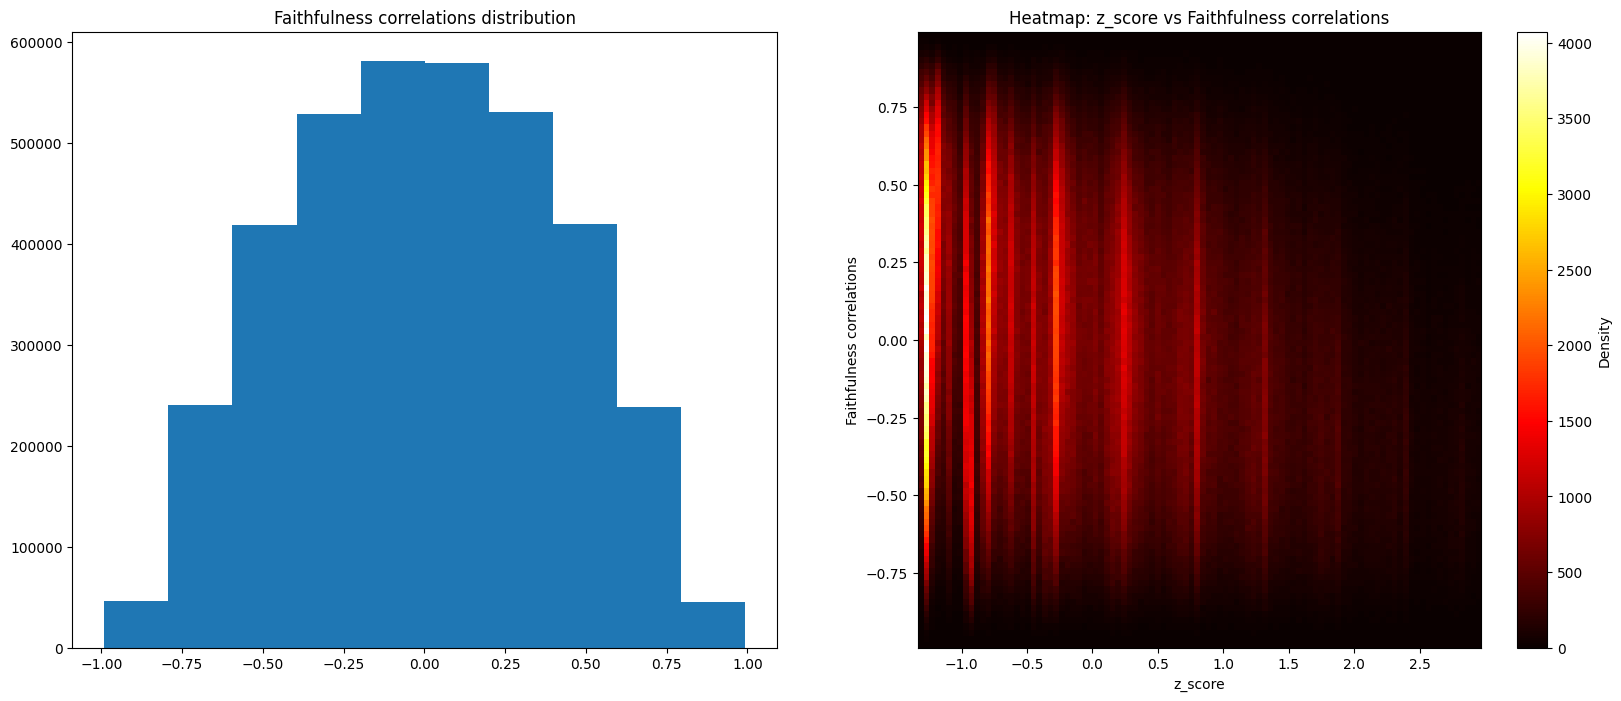

Pearson correlation z-score vs Faithfulness correlations (exceptional):0.0026254237506716507


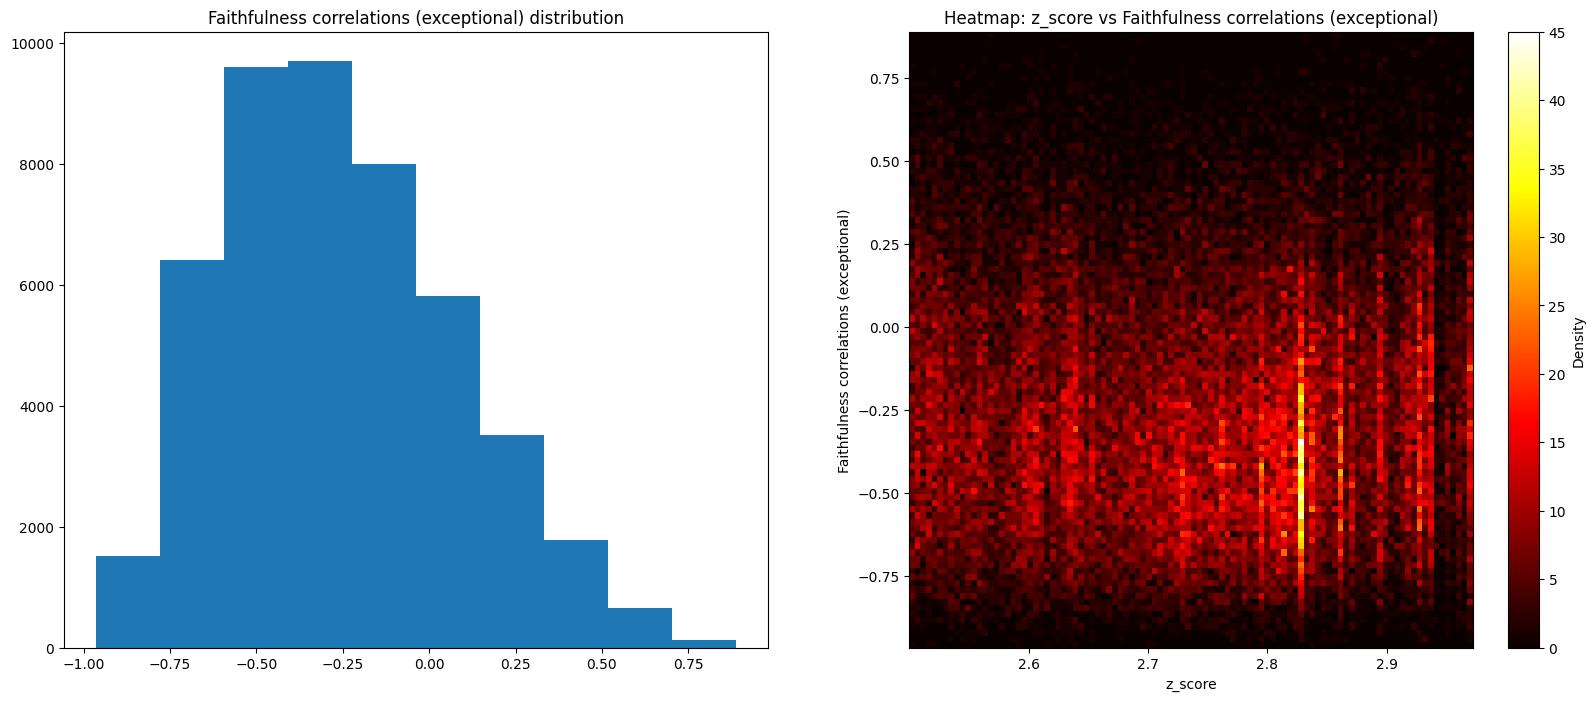

Pearson correlation z-score vs Monotonicity correlations:-0.14008877992001656


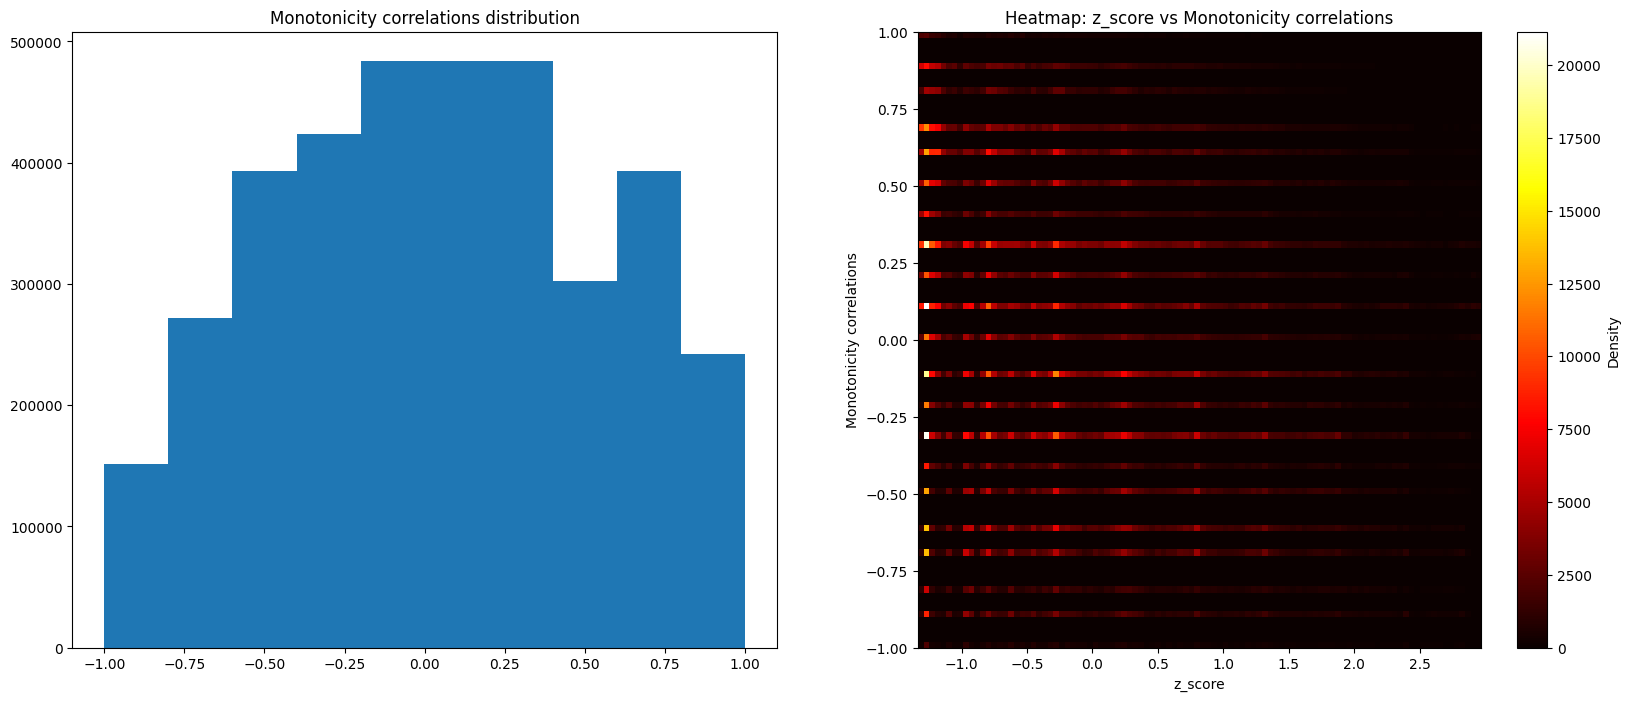

Pearson correlation z-score vs Monotonicity correlations (exceptional):0.18418977929314032


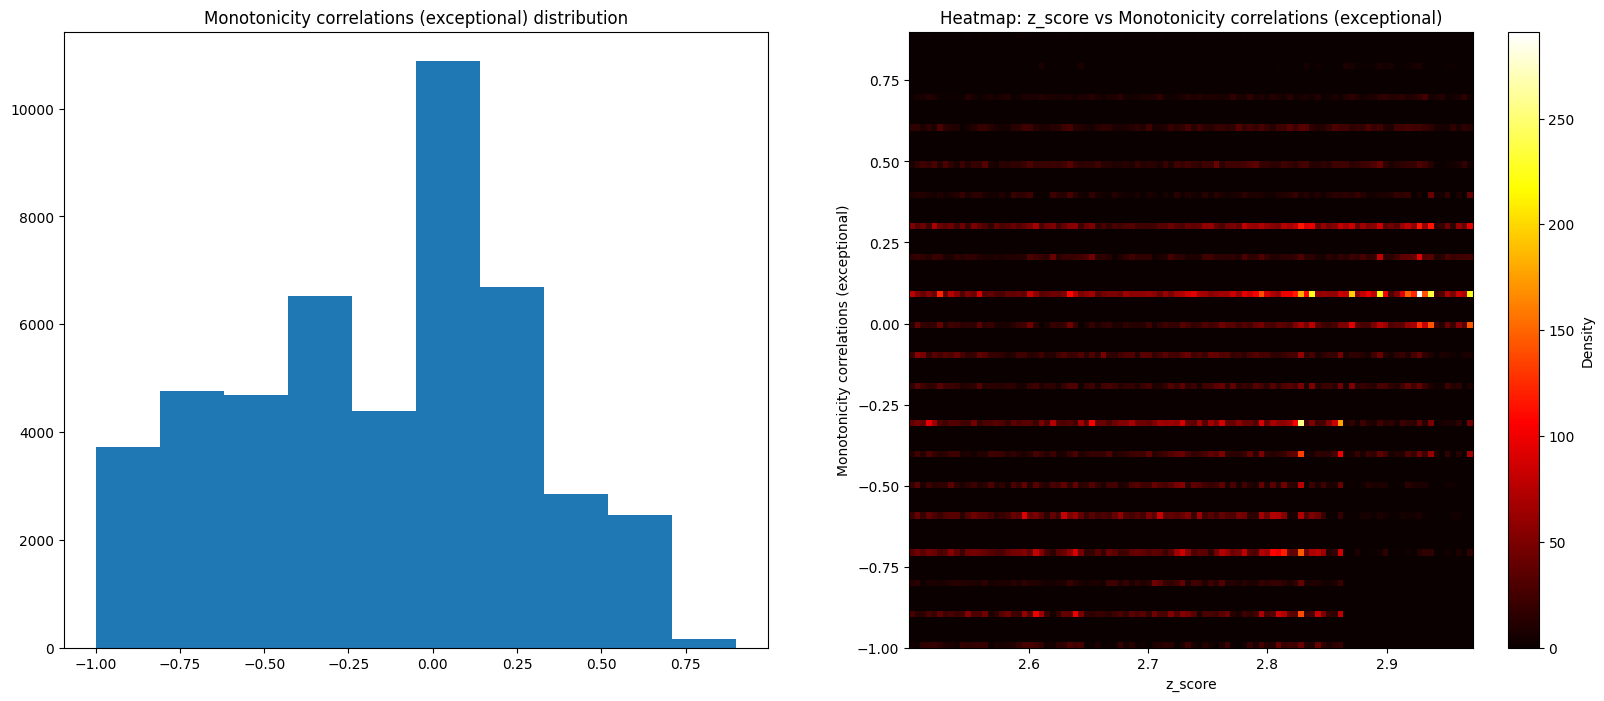

Pearson correlation z-score vs Pixel flipping activations:0.2667712239172927


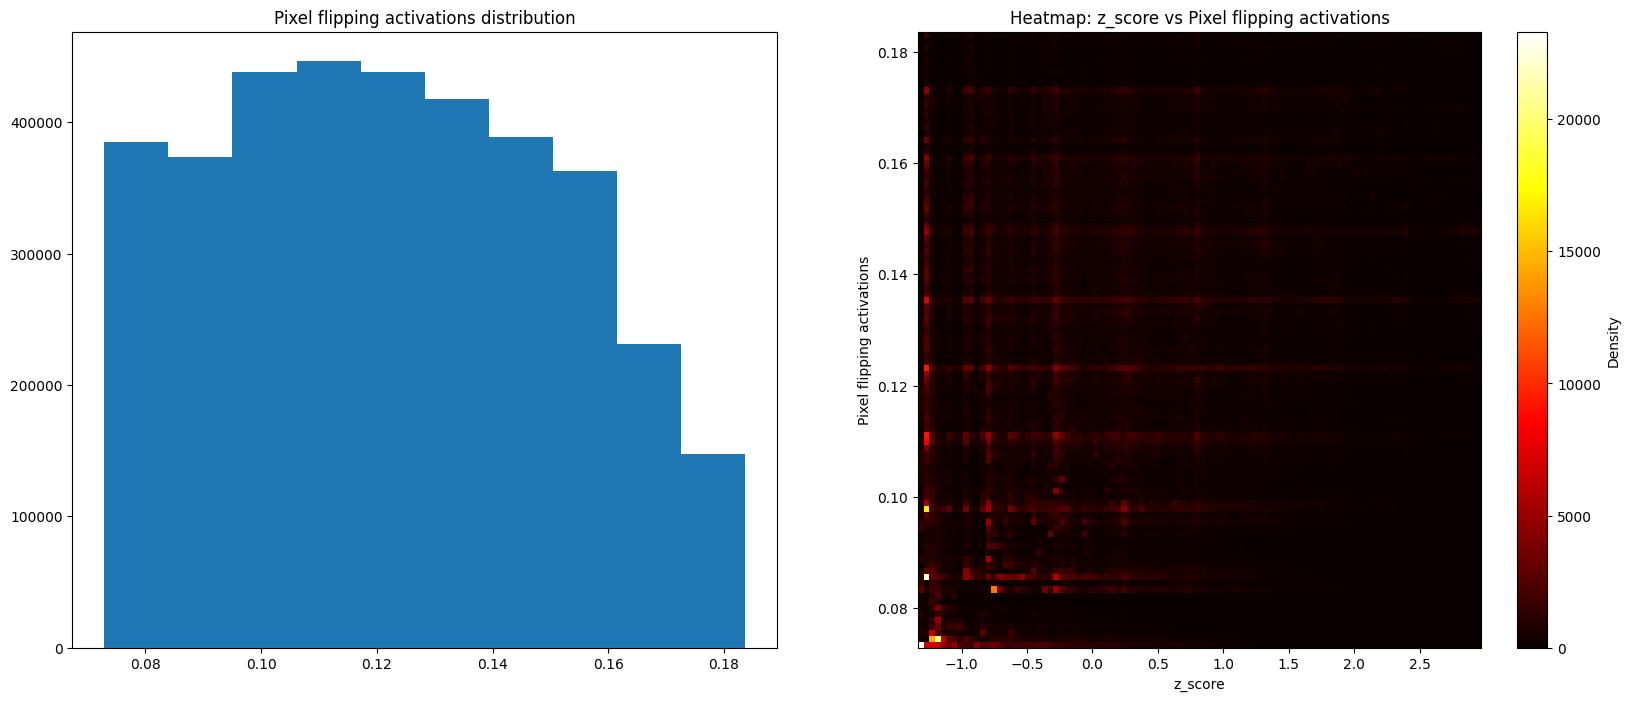

Pearson correlation z-score vs Pixel flipping activations (exceptional):-0.095817752682352


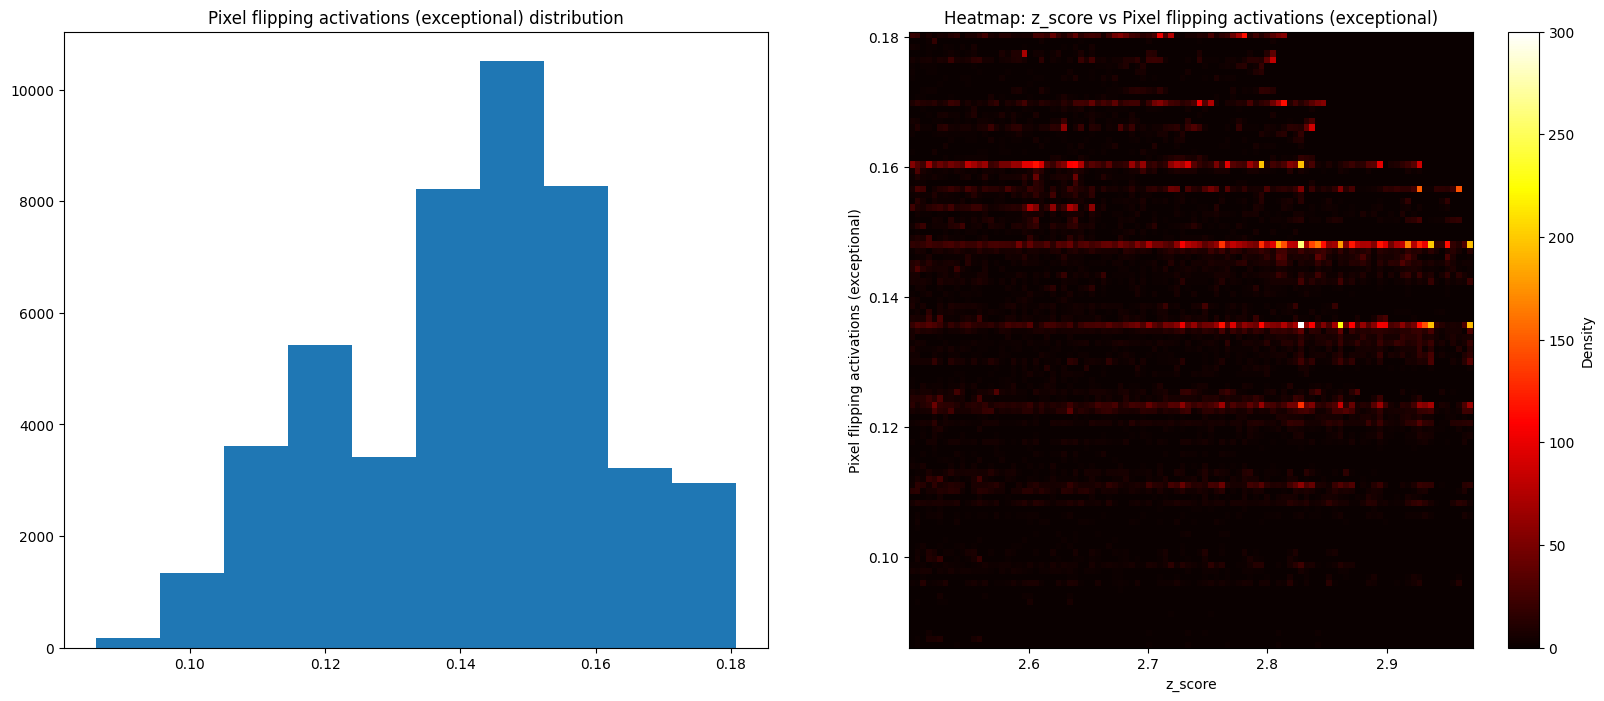

In [19]:
show_performance(z_scores, faithfulness_correlations, f'Faithfulness correlations')
show_performance(z_scores[exceptional_indices], faithfulness_correlations[exceptional_indices], f'Faithfulness correlations (exceptional)')
show_performance(z_scores, monotonicity_correlations, f'Monotonicity correlations')
# The following one gives a remarkable result
show_performance(z_scores[exceptional_indices], monotonicity_correlations[exceptional_indices], f'Monotonicity correlations (exceptional)')
show_performance(z_scores, pixel_flipping_activations, f'Pixel flipping activations')
show_performance(z_scores[exceptional_indices], pixel_flipping_activations[exceptional_indices], f'Pixel flipping activations (exceptional)')


## Explore Qinv across the different levels of exceptionality

2016873 elements with z_score in [-inf,0)
Pearson correlation z-score vs Qmean_inv (z_score in [-inf,0)):0.575338832027139


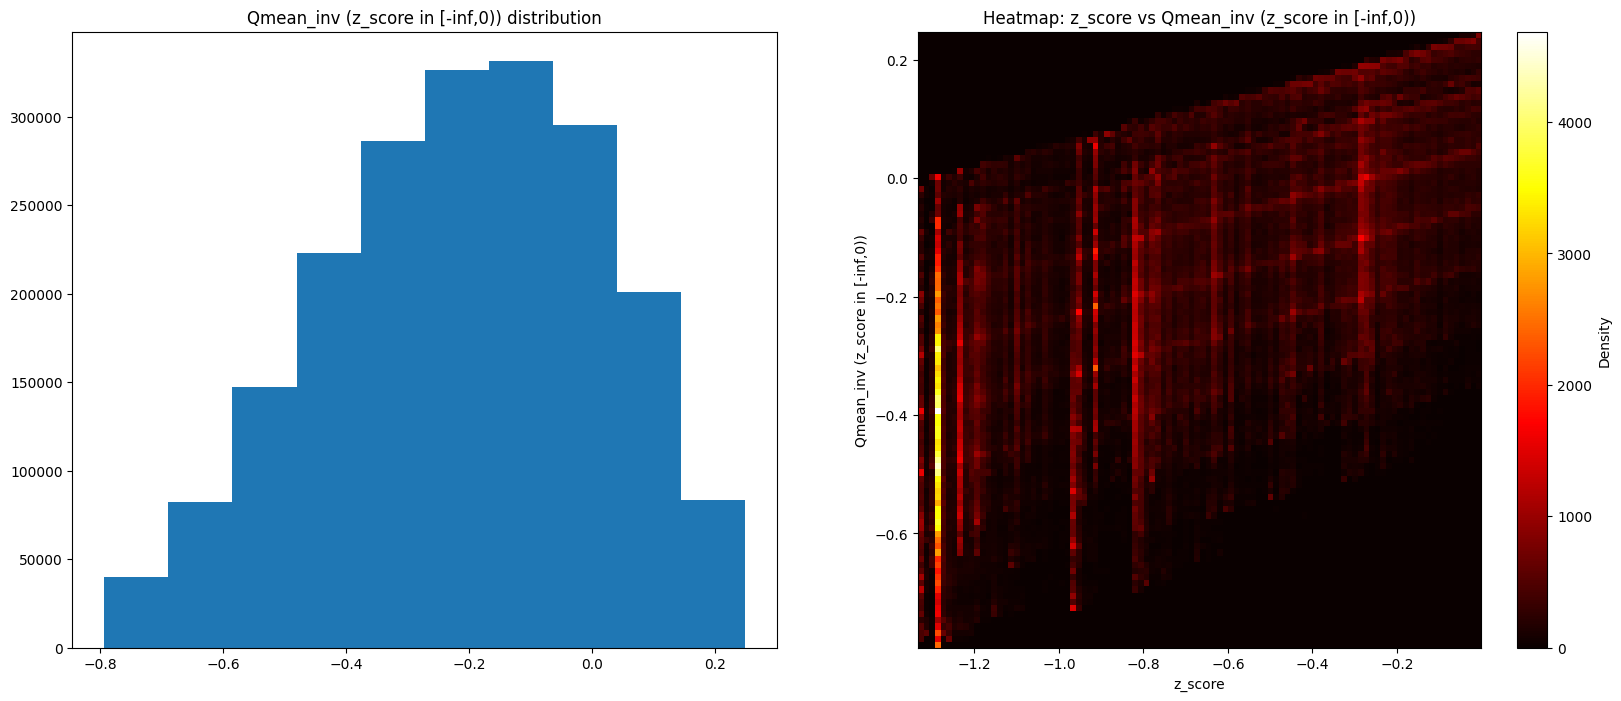

549819 elements with z_score in [0,0.5)
Pearson correlation z-score vs Qmean_inv (z_score in [0,0.5)):0.259614459748377


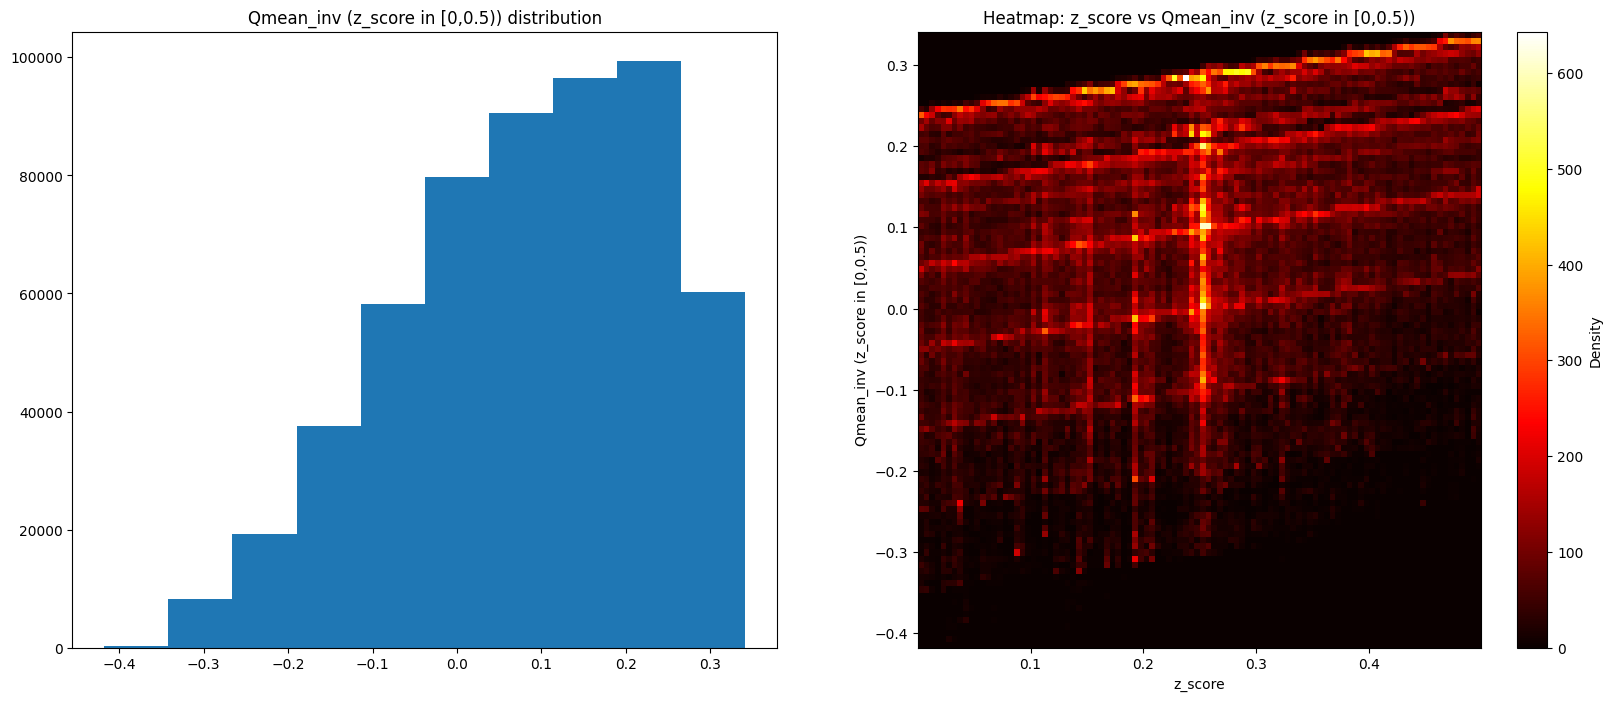

426629 elements with z_score in [0.5,1)
Pearson correlation z-score vs Qmean_inv (z_score in [0.5,1)):0.28679492533514245


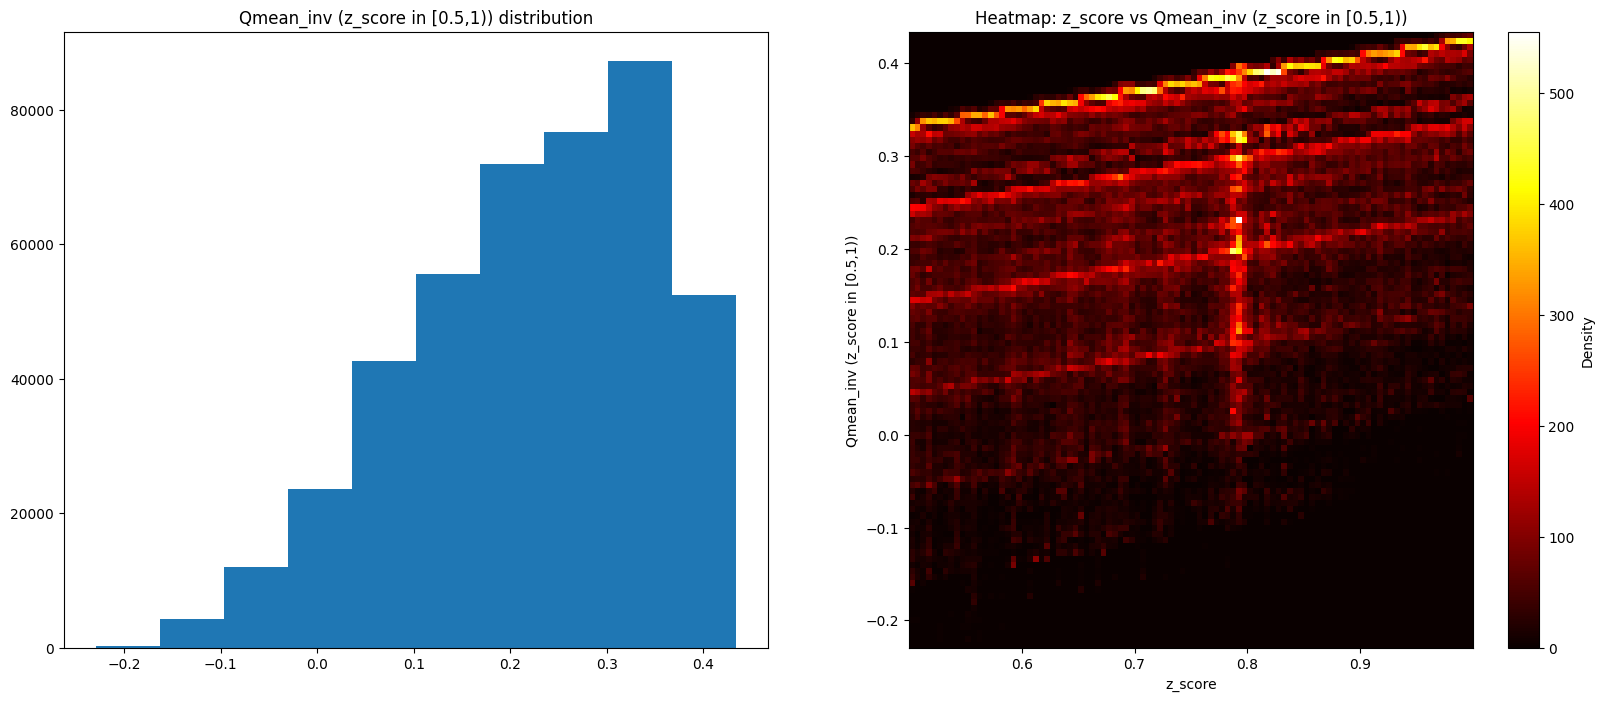

299017 elements with z_score in [1,1.5)
Pearson correlation z-score vs Qmean_inv (z_score in [1,1.5)):0.33263831887909523


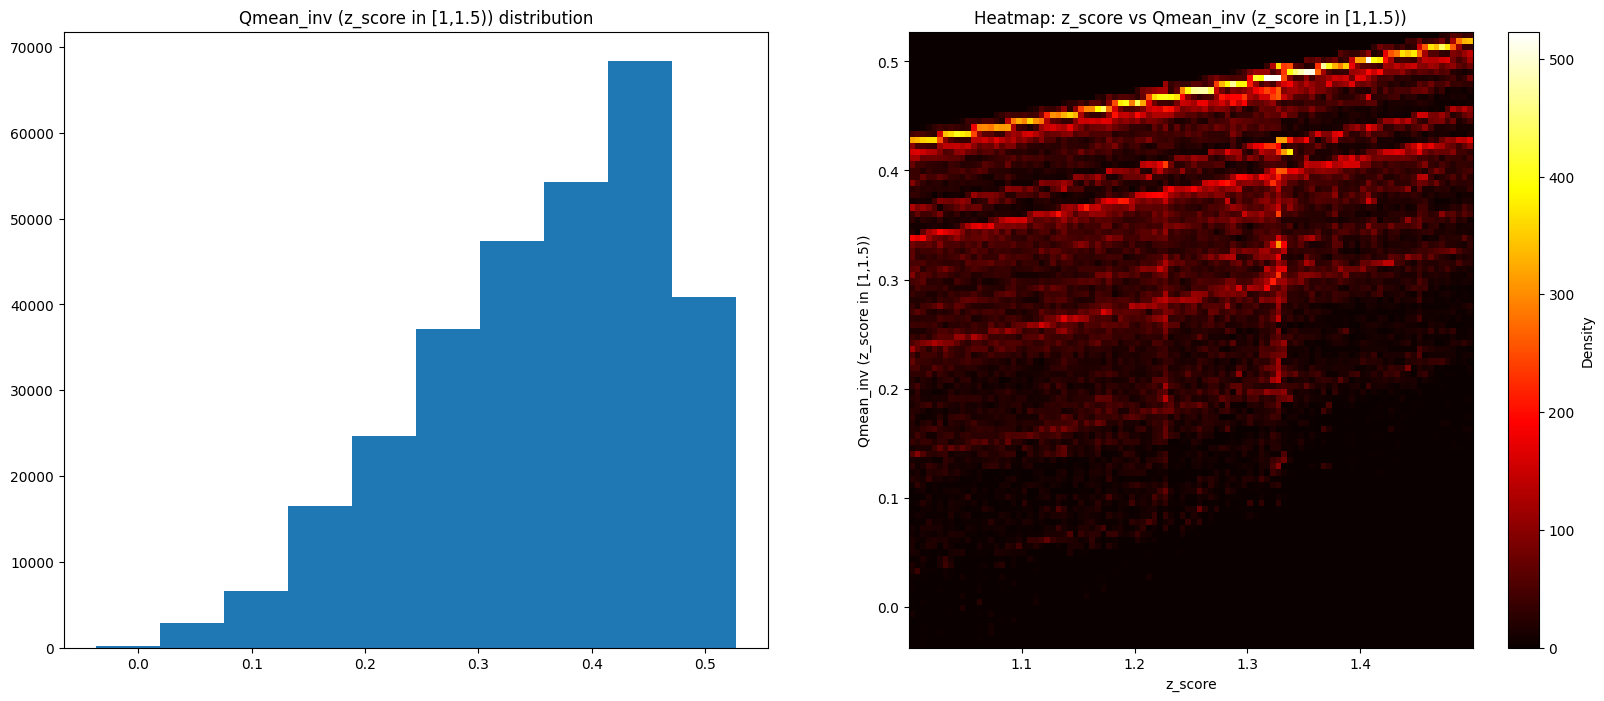

191911 elements with z_score in [1.5,2)
Pearson correlation z-score vs Qmean_inv (z_score in [1.5,2)):0.36621358224661843


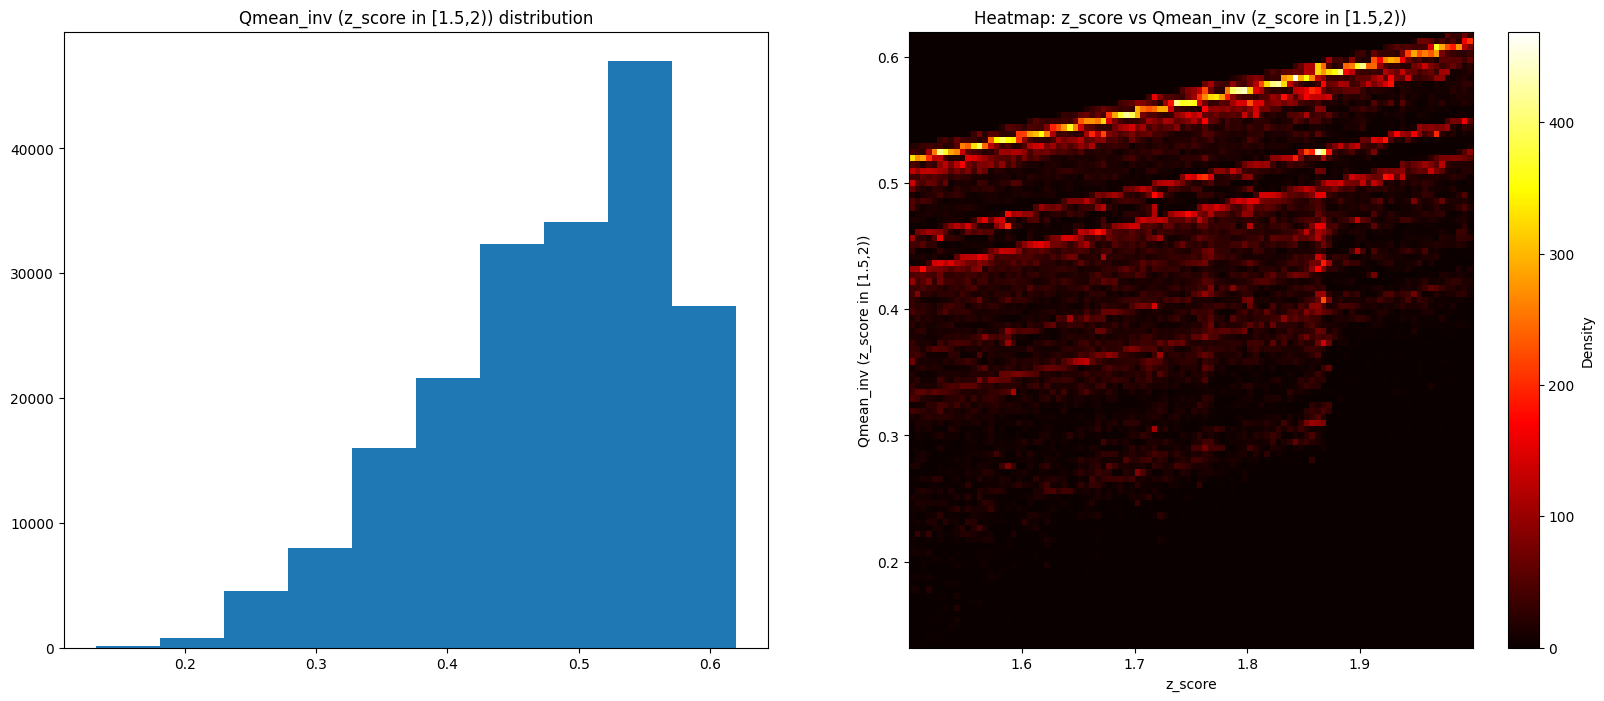

97408 elements with z_score in [2,2.5)
Pearson correlation z-score vs Qmean_inv (z_score in [2,2.5)):0.36146575324320523


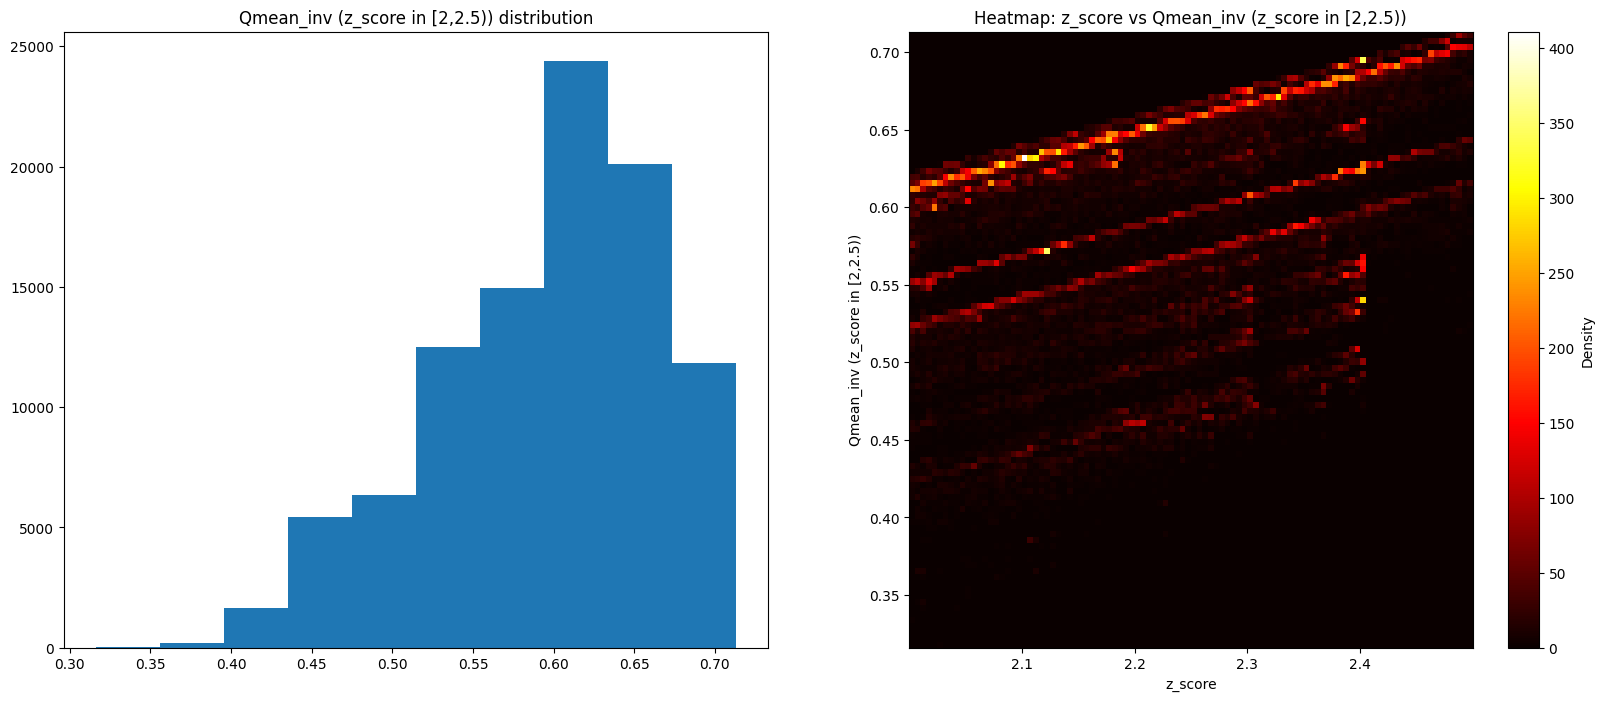

47143 elements with z_score in [2.5,inf)
Pearson correlation z-score vs Qmean_inv (z_score in [2.5,inf)):0.5545883674385237


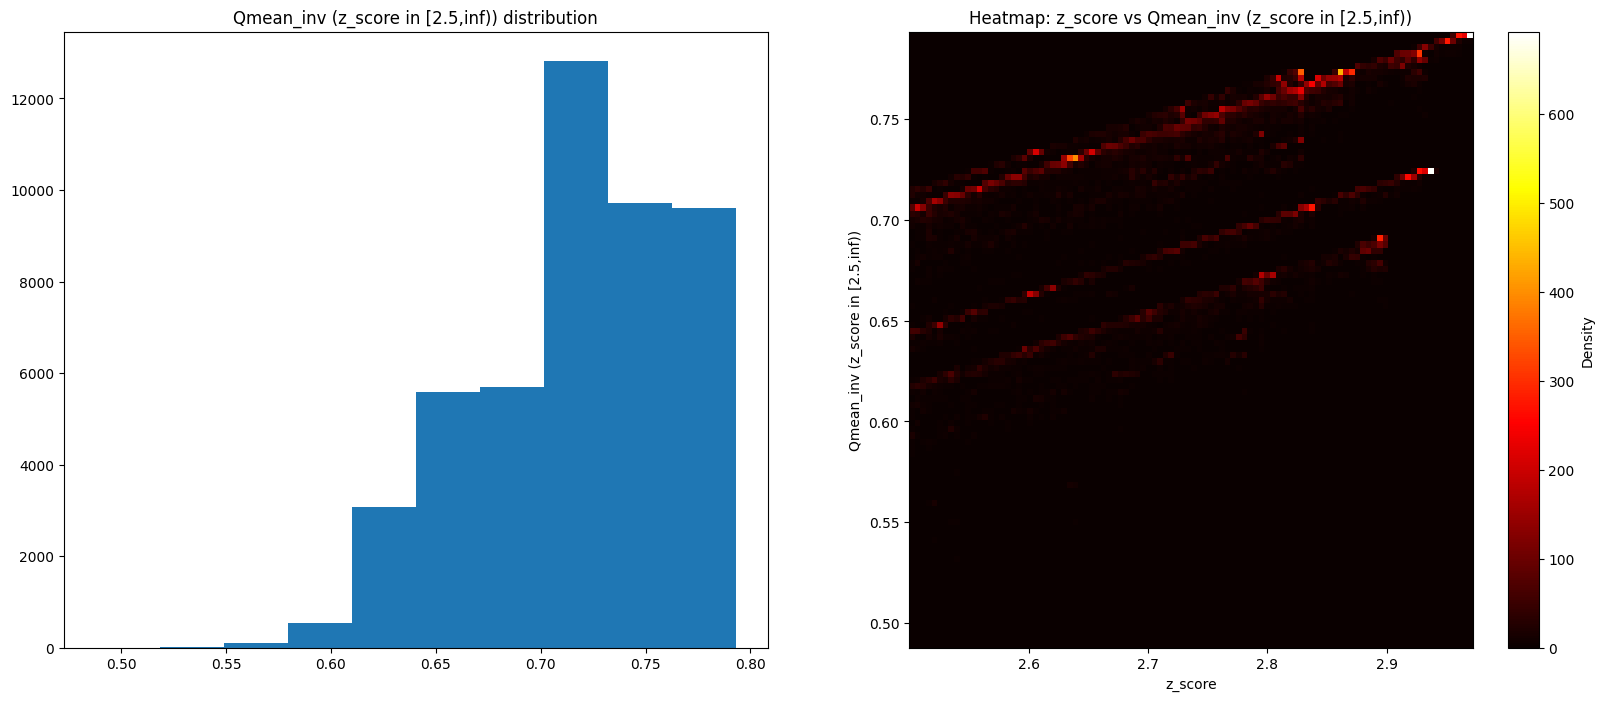

In [20]:
for indices, boundaries in level_indices:
    print(f'{indices.shape[0]} elements with z_score in [{boundaries[0]},{boundaries[1]})')
    show_performance(z_scores[indices], qmean_invs[indices], f'Qmean_inv (z_score in [{boundaries[0]},{boundaries[1]}))')

In [21]:
def attribution_to_ranking(attr):
    return list(map(lambda x:x[1], sorted(list(map(lambda x: (x[1],x[0]),enumerate(attr))))))

print(attribution_to_ranking(data['rankings'][np.argmax(data['faithfulness_correlations'])]))
print(attribution_to_ranking(data['rankings'][np.argmax(data['monotonicity_correlations'])]))
print(attribution_to_ranking(data['rankings'][np.argmax(data['qmeans'])]))
print(attribution_to_ranking(data['rankings'][np.argmax(data['qmean_invs'])]))

top10_faithfulness_correlations = np.argpartition(data['faithfulness_correlations'], -10)[-10:]
top10_monotonicity_correlations = np.argpartition(data['monotonicity_correlations'], -10)[-10:]
top10_qmeans = np.argpartition(data['qmeans'].flatten(), -10)[-10:]
top10_qmean_invs = np.argpartition(data['qmean_invs'].flatten(), -10)[-10:]
print(top10_faithfulness_correlations)
print(top10_monotonicity_correlations)
print(top10_qmeans)
print(top10_qmean_invs)

[1, 5, 0, 9, 8, 7, 6, 3, 2, 4]
[0, 9, 1, 2, 5, 8, 3, 6, 4, 7]
[0, 9, 3, 4, 7, 2, 1, 6, 8, 5]
[0, 9, 7, 3, 4, 2, 1, 6, 8, 5]
[ 755146 2297626 1920875 2217499 1189353 1483155 2241077 2907942 2358630
  760223]
[1199176 1199178 2290109 3013763 1234467 2290113 1199173 1199172 1199171
  185452]
[268071 222807 223527 223557 222687 222837 222717 223551 222711 222831]
[268197 268917 268317 222837 222807 269037 223557 223527 222831 223551]
